In [3]:
#creating deepcopy of model instances
from copy import deepcopy

#array manipulations
import numpy as np

#dataframe and its manipulations
import pandas as pd

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#selected plotting functions
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#classes for grid search and cross-validation, function for splitting data and evaluating models
from sklearn.model_selection import train_test_split,StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve

#XGBoost library
import xgboost as xgb
import glob
#Python standard libraries
import time
import warnings

#setting default resolution of figures
mpl.rcParams['figure.dpi'] = 200

# import ROOT
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import plot_roc_curve
# import uproot
from skopt.plots import plot_objective, plot_histogram


def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = np.unique(y_train, axis = 0)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]
    return sample_weights


def ChangeScaleAndWeight(df,weight,num_range,variable):
    # ChangeScaleAndWeight(pd.DataFrame,list of weight to be multiplied elementwise, num_range which is scaled to -num_range to +num_range,list of variable to run the sacale and weight):
            
    temp = {}
    for key in df:
        array = df[key]
        cut_array = array[array<(np.mean(array)+3*np.std(array))]
        weight = weight[weight<(np.mean(weight)+3*np.std(weight))]
        if key in variable:

            
            
            abs_value = np.amax(np.abs(cut_array))
            scale_array = cut_array*(num_range/abs_value)
                        
            norm = np.linalg.norm(scale_array)
            normal_array = scale_array/norm
            
            
            temp[key]=[i*j for i,j in zip(normal_array,weight)]
        else:
            temp[key]=cut_array
    print(temp)
    print(np.size(temp))
    return pd.DataFrame(temp)


def ChangeScale(df,num_range,variable):
    temp = {}
    for key in df:
        array = df[key]
        cut_array = array[array<(np.mean(array)+3*np.std(array))]

        if key in variable:
            norm = np.linalg.norm(cut_array)
            normal_array = cut_array/norm
            abs_value = np.amax(np.abs(normal_array))
            scale_array = normal_array*(num_range/abs_value)
            temp[key]=scale_array
        else:
            temp[key]=cut_array
    return pd.DataFrame(temp)



def ChangeNorm(df,variable):
    # Normalizate variable to 1 and return the original df
    temp={}
    for key in df:
        if key in variable:
            norm = np.linalg.norm(df[key])
            temp[key] = df[key]/norm
        else:
            temp[key]=df[key]
    return pd.DataFrame(temp)

def ChangeNormV(var):
    norm = np.linalg.norm(var)
    return var/norm


train_variable = ['p_Mjl01','min_DR_tau_lep','p_DR_close_jet_lead_led','min_M_tau_lep','p_DRll01','p_Mjl00','p_Mjjl011']



# train_variable = ['p_Mjl01','min_M_tau_lep','p_DRll01','p_Mjl00','p_Mjjl011']

# input files 
pwd = '/scratch/users/sbataju/2llSS1tauOS/Med/CV'
# all_file = {file_.split('/')[-1]:uproot.open(file_+':nominal').arrays(train_variable+['weight_lumi_xsec'],library="np")  for file_ in list(set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_*.root'))- set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_sig*.root'))- set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_DYMLowZ.root'))- set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_VV.root')))}

# input_signal = uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_signal_New_mcA.root'+':nominal').arrays(train_variable+['weight_lumi_xsec'],library="np") 
# # input_signal_weight = pd.DataFrame.from_dict(uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_signal_New_mcA.root'+':nominal').arrays(['weight_lumi_xsec'],library="np"))
# input_bkg = uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_VV.root'+':nominal').arrays(train_variable+['weight_lumi_xsec'],library="np") 
# # input_bkg_weight = pd.DataFrame.from_dict(uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_VV.root'+':nominal').arrays(['weight_lumi_xsec'],library="np"))


# output files 
# signal_file =uproot.recreate(pwd+'/out4/Med_signal_New.root')
# bkg_file =uproot.recreate(pwd+'/out4/Med_VV.root')
# up_files = { file_.split('/')[-1]:uproot.recreate(pwd+'/out4/'+file_.split('/')[-1]) for file_ in all_file.keys() }

# df_s = pd.DataFrame.from_dict(input_signal)
# # input_signal_weight['class']=1
# df_s['class']=1.0
# # sig_weight = df_s.pop('weight_lumi_xsec')
# df_b = pd.DataFrame.from_dict(input_bkg)
# df_b['class']=0.0
# # input_bkg_weight['class']=0
# # bkg_weight = df_b.pop('weight_lumi_xsec')


# # sig_bkg_weight = input_signal_weight.append(input_bkg_weight)
# # print(sig_bkg_weight,'sig_bkg_weight')

# X =df_s.append(df_b)
X = pd.read_csv('train_test.csv')
X = X[X["weight_lumi_xsec"]>=0]
X = X.sample(frac=1).reset_index(drop=True) # Sample  

print("^^^^^^df")
print(X)
weight = X.pop("weight_lumi_xsec")
# X = ChangeScale(X,100,train_variable)
y = X.pop('class')
X = ChangeNorm(X,train_variable)
# y = y.replace(100,1)

# data = X
# label = pd.DataFrame(y)
# dtrain = xgb.DMatrix(data, label=label,weight=weight)
# print(dtrain)
ps = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
kfold = ps.split(X,y)
print(kfold)
import optuna

from optuna import Trial, visualization
assert False
# import sklearn.datasets
# import xgboost as xgb
def objective(trial):


    dtrain = xgb.DMatrix(X, label=pd.DataFrame(y),weight=weight)
#     ratio = float(np.sum(weight[y == 0])) / np.sum(weight[y==1])

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "gpu_hist",
        "n_estimators": trial.suggest_int("n_estimators",200,2000,100),
        'colsample_bytree': trial.suggest_float('colsample_bytree',0.3,1.0,log=True),
        'colsample_bynode': trial.suggest_float('colsample_bynode',0.3,1.0,log=True),
        'colsample_bylevel': trial.suggest_float("colsample_bylevel",0.3,1.0,log=True),
         #"booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight",0,15)
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-logloss")
    history = xgb.cv(param, dtrain, num_boost_round=50, callbacks=[pruning_callback],nfold=5,stratified=True)

    mean_log_loss = history["test-logloss-mean"].values[-1]
    return mean_log_loss

best_est = {}
# storage_name = "sqlite:///{}.db".format(study_name)
if __name__ == "__main__":
    study_name = "study_weightnormed"  # Unique identifier of the study.
    storage_name = "sqlite:///{}.db".format(study_name)
    n_boost =50
#     pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    study = optuna.create_study(study_name=study_name, direction="minimize",storage=storage_name)

#     study = optuna.create_study(study_name=study_name,pruner=pruner, direction="minimize",storage=storage_name)
    study.optimize(objective, n_trials=300)
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial for N_trees {} : ".format(n_boost))
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    best_est[n_boost] = trial.params
    for key, value in trial.params.items():
        print("    {}= {}".format(key, value))

print(" best values for tress",best_est)




history = study.trials_dataframe()
history.sort_values(by="value", ascending=True).to_csv(f'{study_name}.csv')

# f=plt.figure()
# visualization.plot_slice(study, target_name = 'Average Validation LogLoss')
# plt.savefig('plot_slice.png')
# plt.close(f)

# f=plt.figure()
# visualization.plot_optimization_history(study, target_name = 'Average Validation LogLoss')
# plt.savefig('plot_optimization_history.png')
# plt.close(f)

# f=plt.figure()
# visualization.plot_parallel_coordinate(study, target_name = 'Average Validation LogLoss')
# plt.savefig('plot_parallel_coordinate.png')
# plt.close(f)

# f=plt.figure()
# visualization.plot_param_importances(study, target_name = 'Average Validation LogLoss')
# plt.savefig('plot_parallel_coordinate.png')
# plt.close(f)


























assert False
# X = ChangeScaleAndWeight(X,X['weight_lumi_xsec'],100,train_variable)

#train test split with randomization performed (althoughsplit_indexdomization is not necessary)
X_train0, X_test0, y_train0, y_test0 = train_test_split(X[train_variable],y, test_size=0.25,random_state=0)



# y_df = df.pop('class')

test_fold = [1]*int(len(X)/5)+[2]*int(len(X)/5)+[3]*int(len(X)/5) + [4]*int(len(X)/5) + [0]*int(len(X)/5)
# #print(split_index)
# ps = PredefinedSplit(test_fold)
# #print(ps.get_n_splits())

# sk = StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
ps = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
bkg_fold = {}
for key in all_file.keys():
    df1 = all_file[key][train_variable[0]]
    bfold =  [1]*int(len(df1)/5)+[2]*int(len(df1)/5)+[3]*int(len(df1)/5) + [4]*int(len(df1)/5)+ [0]*int(len(df1)/5)
    bkg_fold[key] = PredefinedSplit(bfold)
    # #print([y for x,y in bkg_fold[key].split()],f' bkg_fold  {key}')
    count =0
    for train_key,test_key in bkg_fold[key].split():
        count +=1
        bkg_fold[f'{count}'+key+'train'] = pd.DataFrame.from_dict(all_file[key])[train_variable].iloc[train_key]
        bkg_fold[f'{count}'+key+'test'] = pd.DataFrame.from_dict(all_file[key])[train_variable].iloc[test_key]
        bkg_fold[f'{count}'+key+'weight'] = pd.DataFrame.from_dict(all_file[key])['weight_lumi_xsec'].iloc[test_key]
        bkg_fold[f'{count}'+key+'testkey'] = test_key
# X = np.concatenate((X_train0,X_test0),axis=0)
# y = np.concatenate((y_train0,y_test0),axis=0)
weight = X.pop("weight_lumi_xsec")
nweight = weight
print("vvvv X,y,w")
print(X)
print(y)
print(weight)
print(nweight)
print("^^^^ X,y,w")

# ratio = float(np.sum(y == 0)) / np.sum(y==1)
ratio = float(np.sum(weight[y == 0])) / np.sum(weight[y==1])
param_grid = {'gamma': Real(0.0,10.0,prior='uniform'),
              'learning_rate': Real(0.1,0.9,prior='uniform'),
              'max_depth': Integer(3,14,prior='uniform'),
              'min_child_weight':Integer(1,5,prior='uniform'),
              'n_estimators': Integer(10,250,prior='uniform'),
              'reg_alpha':  Real(1,10.0,prior='uniform'),
              'reg_lambda':  Real(0.0,10.0,prior='uniform'),
              'subsample':Real(0.3,1.0,prior='log-uniform'),
              # 'scale_pos_weight':[ratio],
              'grow_policy':Categorical(["depthwise","lossguide"]),
              'colsample_bytree': Real(0.3,1.0,prior='log-uniform'),
              'colsample_bynode': Real(0.3,1.0,prior='log-uniform'),
              'colsample_bylevel':Real(0.3,1.0,prior='log-uniform')}

print(param_grid)

#setting grid of selected parameters for iteration
# param_grid = {'gamma': Real(0.1,10.0,prior='uniform'),
#               'learning_rate': Real(0.1,0.9,prior='uniform'),
#               'max_depth': Integer(3,14,prior='uniform'),
#               'n_estimators': Integer(10,250,prior='uniform'),
#               'reg_alpha':  Real(0.0,10.0,prior='uniform'),
#               'reg_lambda':  Real(0.0,10.0,prior='uniform'),
#               'subsample':Real(0.3,1.0,prior='log-uniform'),
#               'grow_policy':Categorical(["depthwise","lossguide"]),
#               'colsample_bytree': Real(0.3,1.0,prior='log-uniform'),
#               'colsample_bynode': Real(0.3,1.0,prior='log-uniform'),
#               'colsample_bylevel':Real(0.3,1.0,prior='log-uniform')}
#No. of jobs
# gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]
gcvj=30

assert False
print(gcvj)
gcvj=int(gcvj)

largest_class_weight_coef = max(pd.Series(y).value_counts().values)/X.shape[0]
w = CreateBalancedSampleWeights(y, largest_class_weight_coef)


xgbc = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='logloss',
                          tree_method='gpu_hist',
                          use_label_encoder=False)
xgbc.fit(X_train0,y_train0)
clf = BayesSearchCV(estimator=xgbc, search_spaces=param_grid, n_iter=gcvj, scoring='neg_log_loss', cv=ps, return_train_score=True, verbose=3,n_jobs=-1,error_score=0.99)#,fit_params={'sample_weight': nweight}

# clf = BayesSearchCV(estimator=xgbc, search_spaces=param_grid, n_iter=gcvj, scoring='neg_log_loss', cv=ps, return_train_score=True, verbose=3,n_jobs=-1,error_score=-0.99,fit_params={'sample_weight': nweight})#,fit_params={'sample_weight': nweight}
clf.fit(X, y)

# fig = plt.figure()
# plot_objective(clf.optimizer_results_[0],dimensions=["gamma", "learning_rate", "max_depth","min_child_weight", "n_estimators","reg_alpha","reg_lambda","subsample","grow_policy","colsample_bytree","colsample_bynode","colsample_bylevel"])
# plt.savefig('out4/optimizer_results.png')
# plt.close(fig)

#results dataframe
df = pd.DataFrame(clf.cv_results_)

bp = clf.best_params_
be = clf.best_estimator_

print("**********************\n")
print("<<<<<<<CV DONE>>>>>>>>\n")
print("**********************\n")
# print(results_dict['xgbc_bcv'])

# print('best params ',results_dict['xgbc_bcv'] )

print(pd.DataFrame(clf.cv_results_))
pd.DataFrame(clf.cv_results_).to_csv('out4/Gpu_test_cvr.csv')



from sklearn.metrics import plot_roc_curve

results_dict={}
c=0                                                                                       #OrderedDict([('gamma', 1.6), ('learning_rate', 0.03), ('max_depth', 12), ('n_estimators', 150), ('reg_alpha', 0.8), ('reg_lambda', 0.2)])}
##'best_params': OrderedDict([('gamma', 1.6), ('learning_rate', 0.6), ('max_depth', 10), ('n_estimators', 65), ('reg_alpha', 3.2), ('reg_lambda', 12.8)])}
for train_index, test_index in ps.split(X,y):
# for train_index, test_index in sk.split(X,y):
    c +=1
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_trainw, X_testw = nweight.iloc[train_index],nweight.iloc[test_index]
    
    
    largest_class_weight_coef = max(pd.Series(y).value_counts().values)/X.shape[0]
    w = CreateBalancedSampleWeights(y_train, largest_class_weight_coef)

    # for feature in X_train:
    #     figure = plt.figure()
    #     plt.hist(X_train[y_train==1][feature],w[y_train==1],label='sig balanced w')
    #     plt.hist(X_train[y_train==0][feature],w[y_train==0],label='bkg balanced w')
    #     plt.savefig(f'out4/{feature}_{c}.png')
    #     plt.close(figure)


    print('\n xtrain \n')
    print(X_train)
    print('\n ytrain \n')
    print(f'\n signal/Total {sum(y_train)/len(y_train)} \n')
    print(y_train)
    print('\n xtest \n')
    print(X_test)
    print('\n xtrainw \n')
    print(X_trainw)
    
    # largest_class_weight_coef = max(pd.Series(y).value_counts().values)/df.shape[0]
    # weight = CreateBalancedSampleWeights(y_train, largest_class_weight_coef)
    #XGBClassifier default parameters are not available without fitting the model
    # xgbc0 = cv_result['xgbc_bcv']['best_estimator']                                                                          # 'best_params': OrderedDict([('gamma', 3.2),('learning_rate', 0.06),('max_depth', 7),('n_estimators', 80),('reg_alpha', 0.0),('reg_lambda', 6.4)])}}
    # xgbc0 = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', eval_metric='logloss', use_label_encoder=False ,gamma=3.2,learning_rate=0.06,max_depth=7,n_estimators=80,reg_alpha=0.0,reg_lambda=6.4)
    print("\n best params \n")
    print(clf.best_estimator_.get_params())
    xgbc0= xgb.XGBClassifier(**clf.best_estimator_.get_params())
    print(xgbc0)
    xgbc0.fit(X_train,y_train)#,sample_weight=X_trainw

    # xgbc0.fit(X_train,y_train,sample_weight=X_trainw)#,sample_weight=X_trainw

    results_dict[f'clf{c}_train_prob'] = xgbc0.predict_proba(X_train)
    results_dict[f'clf{c}_test_prob'] = xgbc0.predict_proba(X_test)
    results_dict[f'y_test{c}'] = y_test
    results_dict[f'y_train{c}'] = y_train
    results_dict[f'clf{c}'] = xgbc0
    results_dict[f'X_train{c}'] = X_train
    results_dict[f'X_test{c}'] = X_test

    results_dict[f'{c}_test_weight'] = X_testw

    # results_dict[f'X_test_weight{c}'] = df.iloc[test_index]['weight_lumi_xsec']
    #print("X_weight_sig",X_weight_sig,type(X_weight_sig))
    
    print("*** HH VV \n")
    print(xgbc0.predict_proba(X_test))
    pd.DataFrame(xgbc0.predict_proba(X_test)).describe()
    # assert False
    fig = plt.figure()
    plt.bar(range(len(xgbc0.feature_importances_)), xgbc0.feature_importances_)
    # plt.set_xticks(results_dict['clf1'].feature_importances_)
    # plt.set_xticklabels(train_variable)
    plt.xticks(range(len(xgbc0.feature_importances_)), train_variable)
    # plt.show()
    plt.savefig(f'out4/test1_gpu_featureimp_{c}.png')
    plt.close(fig)

    # fig, ax = plt.subplots(figsize=(12, 6))
    # ax.set_title("Decision Tree")
    # tree_disp = PartialDependenceDisplay.from_estimator(xgbc0, X, train_variable, ax=ax)
    # plt.savefig(f'out4/PDD_{c}.png')
    # plt.close(fig)
    
    for key in all_file.keys():
        #print("#####&&#####")
        #print(f'{c}'+key)
        #print(bkg_fold[f'{count}'+key+'test'])
        results_dict[f'{c}_{key}_Xtest'] = xgbc0.predict_proba(bkg_fold[f'{count}'+key+'test'])[:,1]
        print(" *** bkg \n")
        print(xgbc0.predict_proba(bkg_fold[f'{count}'+key+'test'])[:,1])
    


#combine all bkgs    
all_out1={}
all_outw={}
for key in all_file.keys():
    all_out1[key] = np.concatenate([results_dict[f'{i}_{key}_Xtest'] for i in [1,2,3,4,5] ]) #no of folds
    all_outw[key] = np.concatenate([bkg_fold[f'{i}'+key+'weight'] for i in [1,2,3,4,5] ]) #no of folds
    # #print(all_outw[key])
    up_files[key].mktree("nominal", {"bdt_out1": np.float64,'weight_lumi_xsec':np.float64})
    #print(all_out1[key]," ### btd out", len(all_out1[key]))
    #print(all_outw[key],' ### weight',len(all_outw[key]))
    up_files[key]["nominal"].extend({"bdt_out1":all_out1[key],"weight_lumi_xsec":all_outw[key]})

    
    
# #print(bkg_data)

out1put_sig = np.concatenate([results_dict['clf{}_test_prob'.format(i)][ results_dict['y_test{}'.format(i)]==1][:,1] for i in [1,2,3,4,5]],axis=0)
out1put_sigtrain = np.concatenate([results_dict['clf{}_train_prob'.format(i)][ results_dict['y_train{}'.format(i)]==1][:,1] for i in [1,2,3,4,5]],axis=0)
out1put_bkg = np.concatenate([results_dict['clf{}_test_prob'.format(i)][ results_dict['y_test{}'.format(i)]==0][:,1] for i in [1,2,3,4,5]],axis=0)
out1put_bkgtrain = np.concatenate([results_dict['clf{}_train_prob'.format(i)][ results_dict['y_train{}'.format(i)]==0][:,1] for i in [1,2,3,4,5]],axis=0)

out1put_sig_w = np.concatenate([results_dict[f'{i}_test_weight'][results_dict['y_test{}'.format(i)]==1] for i in [1,2,3,4,5]],axis=0)
out1put_bkg_w = np.concatenate([results_dict[f'{i}_test_weight'][results_dict['y_test{}'.format(i)]==0] for i in [1,2,3,4,5]],axis=0)




signal_file.mktree("nominal", {"bdt_out1": np.float64,'weight_lumi_xsec':np.float64})
signal_file["nominal"].extend({"bdt_out1":out1put_sig,"weight_lumi_xsec":out1put_sig_w})
# signal_file["nominal"].extend({"weight_lumi_xsec":out1put_sig_w})


bkg_file.mktree("nominal", {"bdt_out1": np.float64,'weight_lumi_xsec':np.float64})
bkg_file["nominal"].extend({"bdt_out1":out1put_bkg,"weight_lumi_xsec":out1put_bkg_w})
# bkg_file["nominal"].extend({"weight_lumi_xsec":out1put_sig_w})





# assert False
f, axes = plt.subplots(nrows=4,ncols=1,figsize=(9,18))
for i,ax in enumerate(axes):
    i=i+1
    rfc_disp = plot_roc_curve(results_dict['clf{}'.format(i)], results_dict["X_test{}".format(i)], results_dict["y_test{}".format(i)], ax=ax)
# plt.show()
plt.savefig('out4/test1_gpu_roc.png')
plt.close(f)

fig  = plt.figure(figsize=(5, 5))
avg_roc = []
avg_fpr = []
avg_tpr = []
tprs = []
base_fpr = np.linspace(0, 1, 101)
for i in [1,2,3,4,5]:
    roc1 = roc_curve(results_dict['y_test{}'.format(i)], results_dict['clf{}_test_prob'.format(i)][:,1])

    fpr,tpr,_=roc1
    avg_roc.append(roc1)
    avg_fpr.append(fpr)
    avg_tpr.append(tpr)
    plt.plot(fpr, tpr, 'b')
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

fig = plt.figure()
plt.plot(base_fpr, mean_tprs, 'r')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('out4/test1_gpu_combroc.png')
# plt.show()
plt.close(fig)
# #print([len(i) for i in avg_fpr])
# #print([len(i) for i in avg_tpr])
# #print([len(i) for i in avg_roc])

fig = plt.figure()
plt.hist(out1put_sig,color='blue',bins='auto',label='Test, Signal',density=True,alpha=0.4)
plt.hist(out1put_sigtrain,color='blue',bins='auto',label='Train, Signal',density=True,alpha=0.4,histtype='step')
plt.hist(out1put_bkg,color='red',bins='auto',label='Test, Bkg',density=True,alpha=0.4)
plt.hist(out1put_bkgtrain,color='red',bins='auto',label='Train, Bkg',density=True,histtype='step')
# plt.yscale('log')
plt.legend()
# plt.show()

plt.savefig('out4/test1_gpu_trainvstest.png')
plt.close(fig)

fig = plt.figure()
plt.hist(out1put_sig,color='blue',bins='auto',label='Test, Signal',density=True,alpha=0.4)
plt.hist(out1put_sigtrain,color='blue',bins='auto',label='Train, Signal',density=True,alpha=0.4,histtype='step')
plt.hist(out1put_bkg,color='red',bins='auto',label='Test, Bkg',density=True,alpha=0.4)
plt.hist(out1put_bkgtrain,color='red',bins='auto',label='Train, Bkg',density=True,histtype='step')
plt.yscale('log')
plt.legend()
# plt.show()

plt.savefig('out4/test1_gpu_trainvstestlog.png')
plt.close(fig)





^^^^^^df
       Unnamed: 0    lep_Pt_0   lep_Pt_1     HT_jets       Mll01      Ptll01  \
0            8391   55798.470  53125.280  224757.970   59189.240   92384.430   
1           29423   31683.516  31638.887  139859.940   77232.766   27315.137   
2           10669   34673.945  21987.322  218524.100   18973.195   56659.800   
3            6417   46933.277  31231.703   82262.280   76279.830   19127.049   
4           26276   35201.684  29938.238  296758.000   46082.293   46086.190   
...           ...         ...        ...         ...         ...         ...   
48202       14778  130706.220  49310.824  286556.400  126089.590  141156.900   
48203         281   50750.610  25902.050   63657.453   74991.190   25069.549   
48204       13192   81039.050  22439.424  384229.220  262690.060  102100.270   
48205        1104  123530.470  20761.018  148112.270   87953.370  122021.234   
48206       10437  104330.055  22244.790  120985.090  107528.450   82695.660   

           HT_lep    DRll01  l

AssertionError: 

In [51]:

def ChangeNorm(df,variable):
    # Normalizate variable to 1 and return the original df
    temp={}
    for key in df:
        if key in variable:
            norm = np.linalg.norm(df[key])
            temp[key] = df[key]/norm
        else:
            temp[key]=df[key]
    return pd.DataFrame(temp)

def ChangeNormV(var):
    norm = np.linalg.norm(var)
    return var/norm

X = pd.read_csv('train_test.csv')
X = X[X["weight_lumi_xsec"]>=0]
X = X.sample(frac=1).reset_index(drop=True) # Sample  

print("^^^^^^df")
print(X)
weight = X.pop("weight_lumi_xsec")
y = X.pop('class')

^^^^^^df
       Unnamed: 0    lep_Pt_0   lep_Pt_1    HT_jets       Mll01      Ptll01  \
0            7887   68168.930  61168.530  165259.20  122534.836   49433.080   
1           21653   43162.383  26369.688  396117.78   43784.812   63863.355   
2             582   31553.695  28760.432  165550.78   63992.410   21017.072   
3           11537   35781.438  26584.734  133610.78   65228.324   30203.000   
4           15442  147460.610  75923.350  165535.73  207112.310   89681.836   
...           ...         ...        ...        ...         ...         ...   
48202       16982   67275.500  43566.490  122137.10  136928.500   24777.463   
48203        5724  287570.100  35586.676  811775.30  196560.140  257177.800   
48204       19135   63501.950  38028.645  139142.03  101447.100   31621.297   
48205        1495  244806.480  24890.229  246344.50  158372.420  225667.700   
48206        4599   87423.440  50826.246  125689.51  148459.770   79294.360   

           HT_lep    DRll01  lep_Phi_0  le

In [52]:
X1 = ChangeNorm(X[train_variable+['weight_lumi_xsec']],train_variable+['weight_lumi_xsec'])
X1

KeyError: "['weight_lumi_xsec'] not in index"

In [53]:
X

Unnamed: 0    lep_Pt_0   lep_Pt_1    HT_jets       Mll01      Ptll01  \
0            7887   68168.930  61168.530  165259.20  122534.836   49433.080   
1           21653   43162.383  26369.688  396117.78   43784.812   63863.355   
2             582   31553.695  28760.432  165550.78   63992.410   21017.072   
3           11537   35781.438  26584.734  133610.78   65228.324   30203.000   
4           15442  147460.610  75923.350  165535.73  207112.310   89681.836   
...           ...         ...        ...        ...         ...         ...   
48202       16982   67275.500  43566.490  122137.10  136928.500   24777.463   
48203        5724  287570.100  35586.676  811775.30  196560.140  257177.800   
48204       19135   63501.950  38028.645  139142.03  101447.100   31621.297   
48205        1495  244806.480  24890.229  246344.50  158372.420  225667.700   
48206        4599   87423.440  50826.246  125689.51  148459.770   79294.360   

           HT_lep    DRll01  lep_Phi_0  lep_Phi_1  ...  p_sublead_jetEta  \
0      129337.460  2.400592   1.789769  -0.574597  ...          1.489508   
1       69532.070  1.283838  -1.317576  -2.157108  ...          1.283049   
2       60314.125  2.617245   1.050781  -2.796866  ...          1.829044   
3       62366.170  2.434931   1.857258  -0.313931  ...          1.540699   
4      223383.970  2.642166   1.272117  -2.386370  ...          1.118246   
...           ...       ...        ...        ...  ...               ...   
48202  110841.984  3.330743  -2.822591   0.185955  ...          0.565426   
48203  323156.780  2.633990   0.871152  -2.784449  ...          1.459010   
48204  101530.590  2.828505   1.378813  -2.146382  ...          0.409451   
48205  269696.720  2.582716   1.870733  -0.610395  ...          1.250023   
48206  138249.690  2.431255   0.232582  -1.797371  ...          0.941103   

       eventID  p_DRmetl0  p_DRmetl1  p_DRmettau0  p_DPhill01    w_lumi  \
0         7887   3.655381   1.986502     2.302404    2.364365  0.000025   
1        21653   0.393478   1.666951     1.787749    0.839532  0.001012   
2          582   1.415861   2.572851     1.416634   -2.435538  0.000814   
3        11537   1.916845   2.711728     2.448772    2.171189  0.000008   
4        15442   1.497077   1.334691     1.950726   -2.624699  0.001738   
...        ...        ...        ...          ...         ...       ...   
48202    16982   3.071909   0.745646     1.950913   -3.008546  0.001959   
48203     5724   0.424897   2.767824     3.211637   -2.627584  0.004584   
48204    19135   0.945020   2.690430     1.787021   -2.757990  0.000373   
48205     1495   2.035777   1.954126     1.192324    2.481127  0.000045   
48206     4599   0.447967   2.699140     2.514508    2.029953  0.000017   

            p_Mmetl0       p_Mmetl1     p_Mmettau0  
0      236856.502688  145754.733006  174019.008624  
1       20445.358956   68222.439484  110228.836894  
2       84417.269722  118127.714478   93284.135035  
3       94661.938351   77410.156519  112225.328480  
4      120390.201007   76409.018593   92328.468255  
...              ...            ...            ...  
48202  257792.570918   53493.766808  118849.185416  
48203  195196.657559  328198.913282  911984.355163  
48204   23607.685831   41439.749509   34965.832407  
48205  128960.178812   37510.013027   36798.543625  
48206   24039.470599   92171.267454   81649.198365  

[48207 rows x 82 columns]

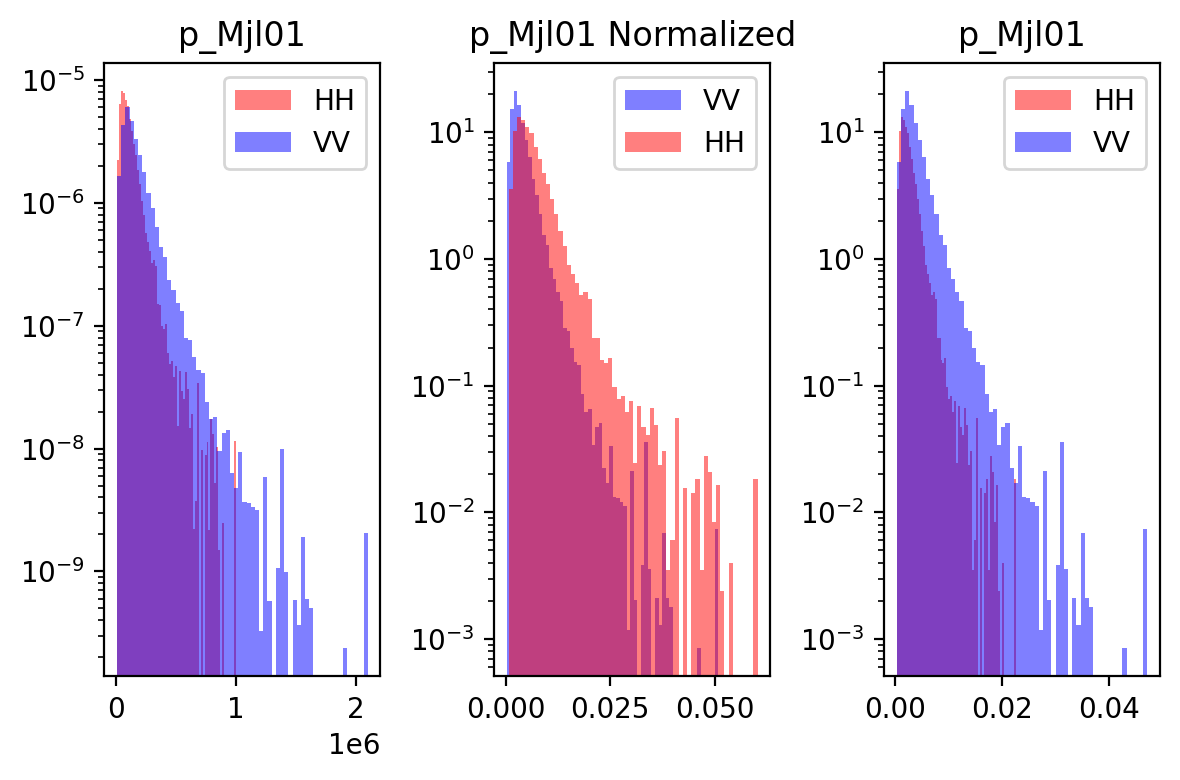

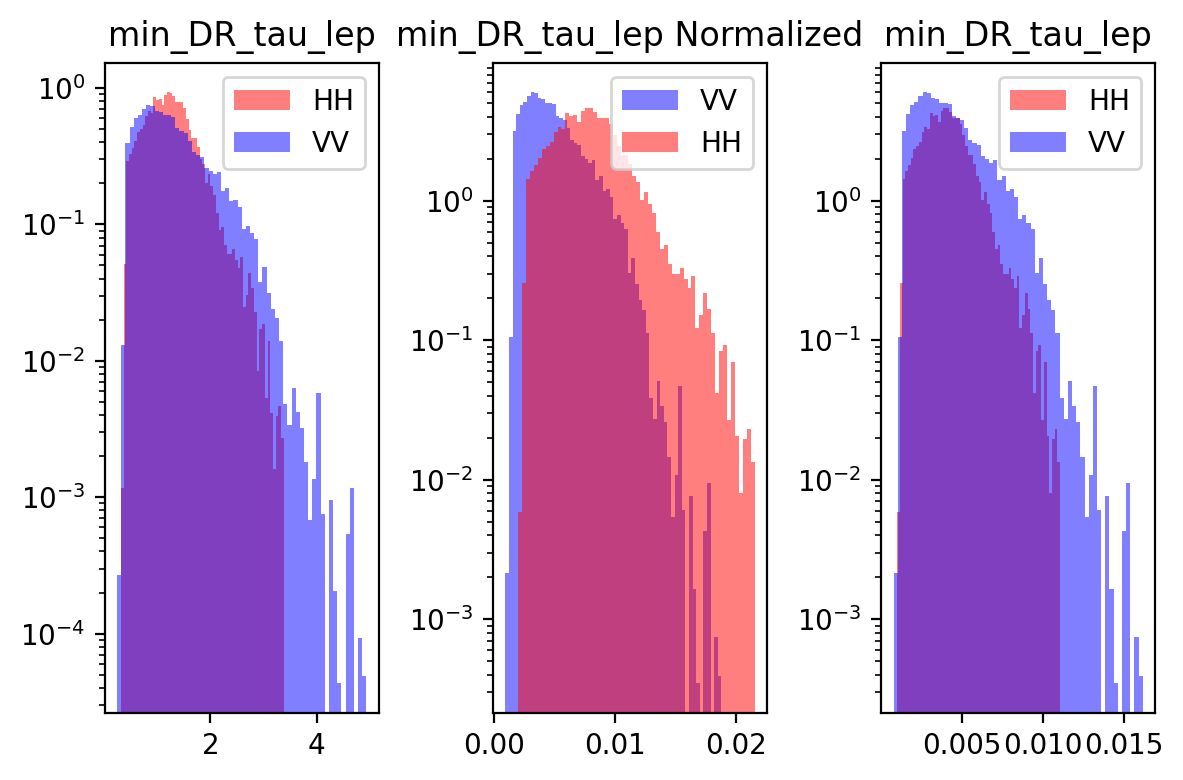

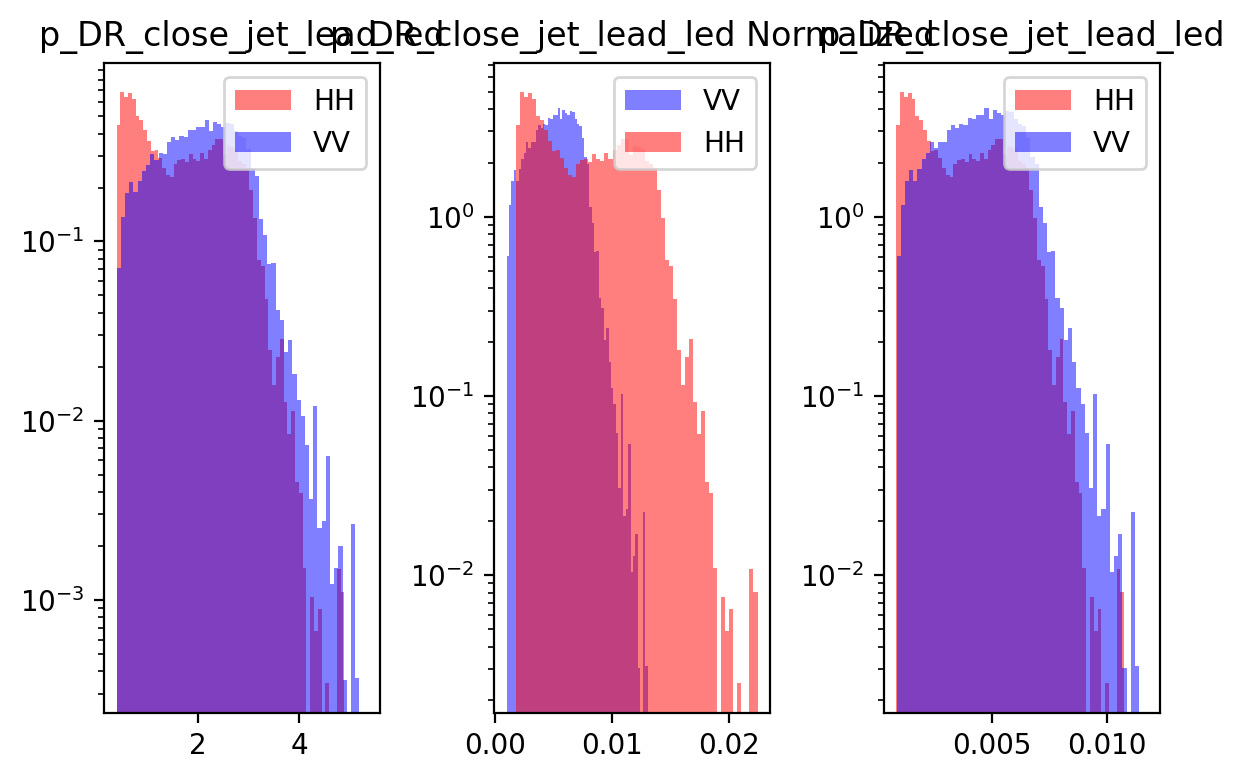

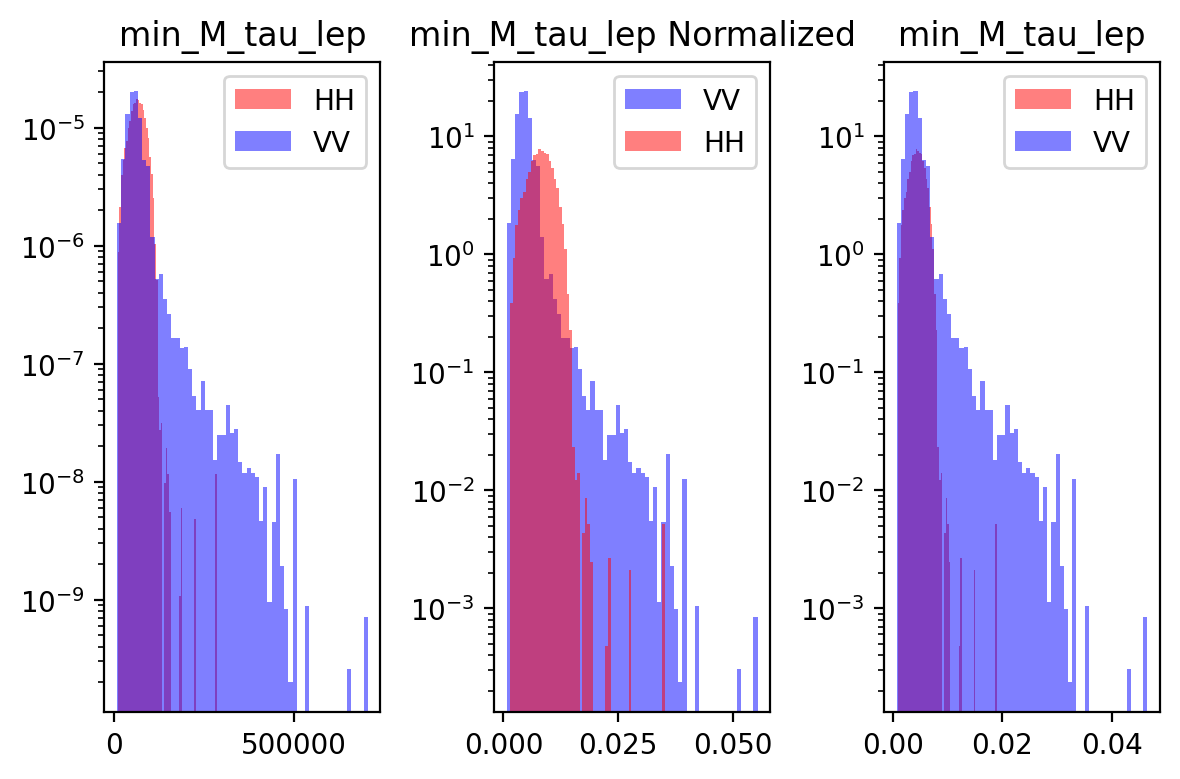

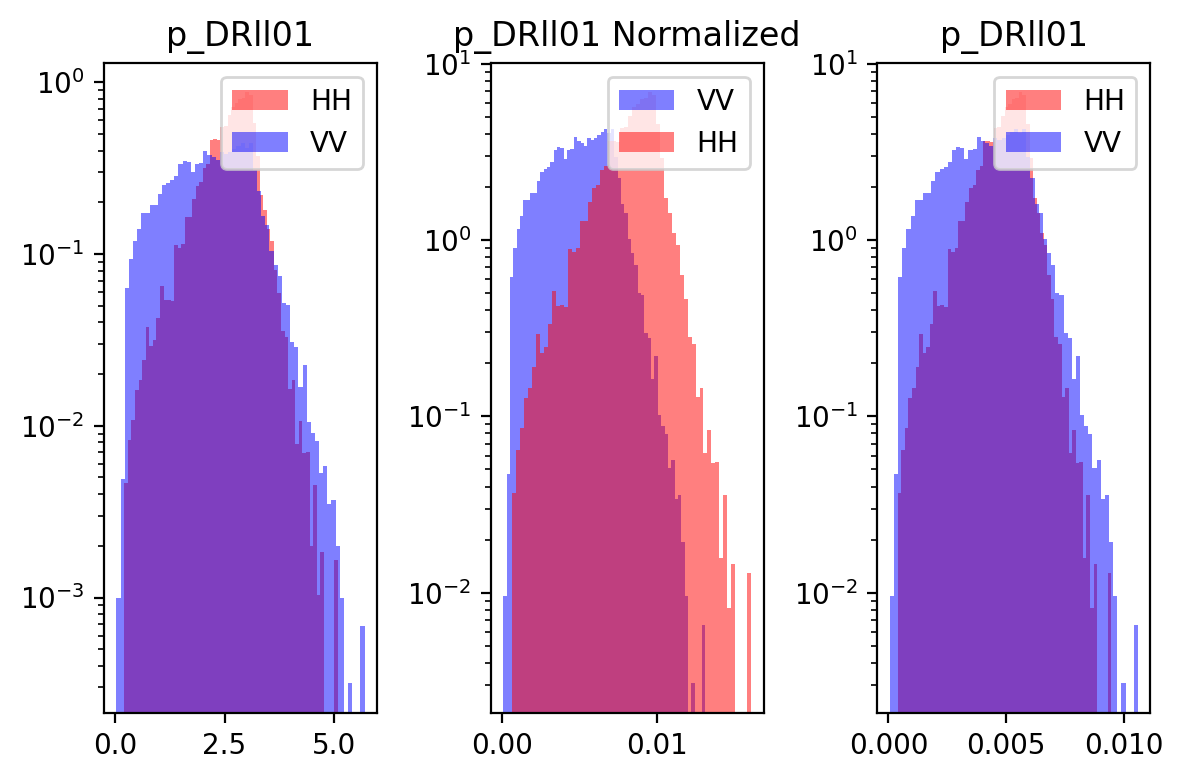

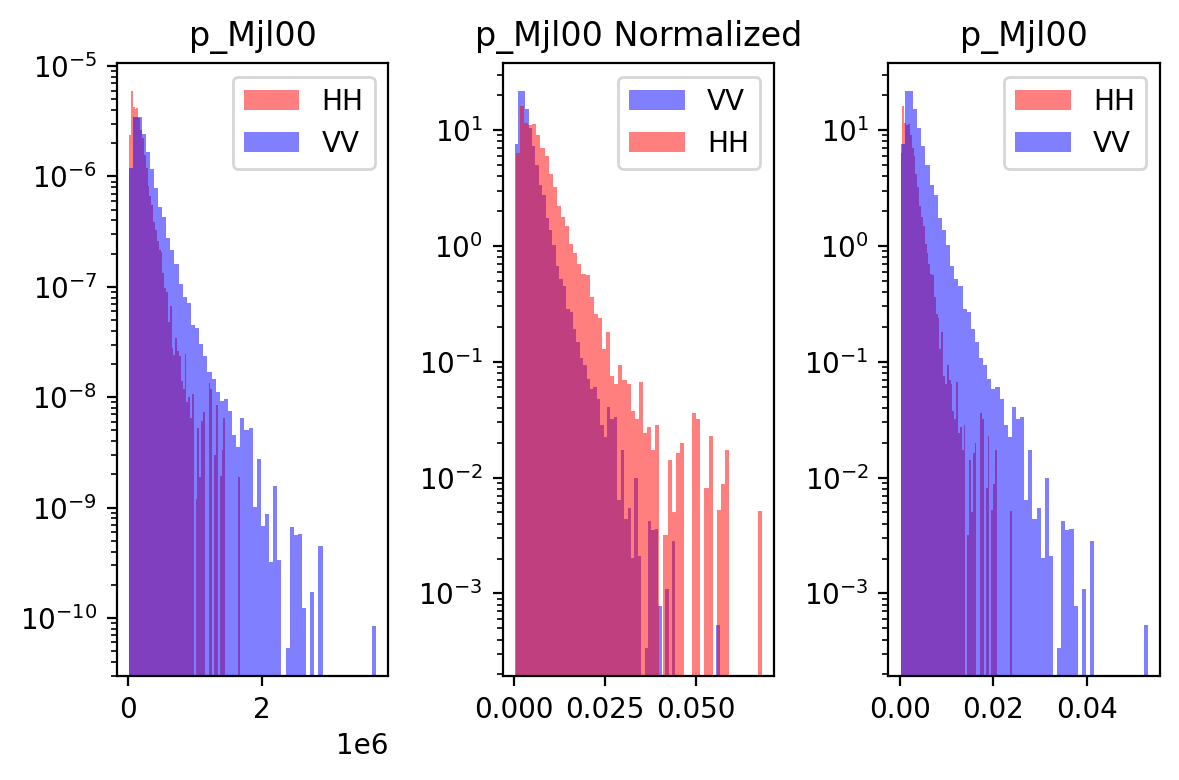

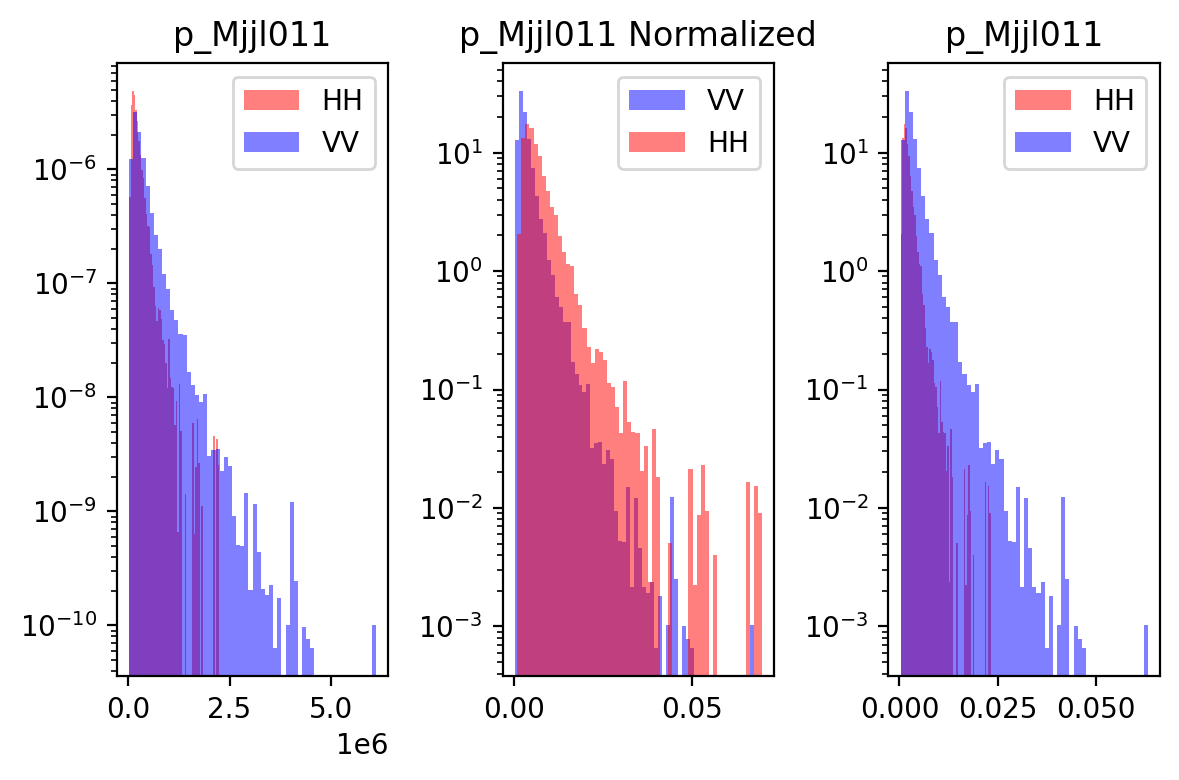

In [60]:
X1 = ChangeNorm(X,train_variable)
hist_dict = {}
for key in X[train_variable]:
    f = plt.figure()
    plt.subplot(131)
    s =plt.hist(X[key][y==1],weights=weight[y==1],bins=60,label='HH',color='red',alpha=0.5,density=True)
    b =plt.hist(X[key][y==0],weights=weight[y==0],bins=60,label='VV',color='blue',alpha=0.5,density=True)
    hist_dict[key+'density'] = [s,b]
    
    plt.tight_layout()
    plt.yscale("log")
    plt.title(key)
    plt.legend()
    plt.subplot(132)
    s=plt.hist(ChangeNormV(X[key][y==0]),weights=ChangeNormV(weight[y==0]),bins=60,label='VV',color='blue',alpha=0.5)
    b=plt.hist(ChangeNormV(X[key][y==1]),weights=ChangeNormV(weight[y==1]),bins=60,label='HH',color='red',alpha=0.5)
    hist_dict[key+'XChangeNormV'] = [s,b]
    
    plt.tight_layout()
    plt.yscale("log")
    plt.title(key+' Normalized')
    plt.legend()
    plt.subplot(133)
    s=plt.hist(X1[key][y==1],weights=ChangeNormV(weight[y==1]),bins=60,label='HH',color='red',alpha=0.5)
    b=plt.hist(X1[key][y==0],weights=ChangeNormV(weight[y==0]),bins=60,label='VV',color='blue',alpha=0.5)
    hist_dict[key+'X1ChangeNormV'] = [s,b]
    
    plt.tight_layout()
    plt.yscale("log")
    plt.title(key)
    plt.legend()
    plt.show()
    plt.close(f)

In [63]:
hist_dict['p_Mjl01density']

[(array([2.23051166e-06, 6.42380001e-06, 8.20143729e-06, 7.86385756e-06,
         6.83001093e-06, 6.18663863e-06, 4.81211488e-06, 3.83463464e-06,
         3.00550647e-06, 2.42846117e-06, 1.85024599e-06, 1.41756423e-06,
         1.02995661e-06, 7.92167650e-07, 5.64272498e-07, 4.76141898e-07,
         4.01980861e-07, 3.24257985e-07, 3.39528046e-07, 3.04071876e-07,
         1.48861579e-07, 1.48292536e-07, 9.99030667e-08, 9.48418113e-08,
         1.04020766e-07, 6.05242616e-08, 4.88085743e-08, 5.20261438e-08,
         3.86038167e-08, 4.68782620e-08, 1.52824939e-08, 4.30824988e-08,
         2.95929492e-08, 2.52725910e-08, 4.16996354e-08, 3.03571996e-08,
         1.47777728e-08, 1.89493308e-08, 2.20203856e-09, 3.74290574e-09,
         3.44902201e-08, 0.00000000e+00, 9.75262559e-09, 0.00000000e+00,
         8.93898093e-09, 1.13621225e-08, 2.18544547e-09, 1.74376127e-08,
         1.30356182e-08, 5.24939173e-09, 1.03175149e-08, 1.48768768e-09,
         0.00000000e+00, 2.47596357e-09, 0.00000000

In [64]:
hist_dict['p_Mjl01XChangeNormV']

[(array([5.86273868e+00, 1.52661050e+01, 2.13736866e+01, 1.64952607e+01,
         1.18030612e+01, 8.74323171e+00, 6.34478995e+00, 4.25854260e+00,
         3.22227982e+00, 2.26512068e+00, 1.55130317e+00, 1.29564509e+00,
         8.46632153e-01, 6.96584127e-01, 5.46392458e-01, 4.65328097e-01,
         2.85176266e-01, 2.71767452e-01, 1.97982635e-01, 1.54468119e-01,
         1.46286894e-01, 8.57888438e-02, 6.19801190e-02, 6.48597815e-02,
         3.41928538e-02, 4.73368594e-02, 5.06835046e-02, 2.24643922e-02,
         1.69355948e-02, 3.34614313e-02, 1.32045675e-02, 1.29089278e-02,
         1.19610931e-02, 1.13102994e-02, 1.16694976e-03, 2.10420565e-02,
         2.04362319e-03, 0.00000000e+00, 3.81049958e-03, 3.56493059e-02,
         3.55953042e-03, 0.00000000e+00, 2.10057547e-03, 1.29544391e-03,
         6.85440699e-03, 2.10820221e-03, 1.79713499e-03, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 8.43633794

In [3]:
study_name = "example-study3"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
# reload study and optimize
study = optuna.load_study(study_name=study_name, storage=storage_name)


In [4]:
visualization.plot_slice(study, target_name = 'Average Validation LogLoss').write_html('plot_slice.html')
visualization.plot_param_importances(study, target_name = 'Average Validation LogLoss').write_html('plot_param_importances.html')
visualization.plot_parallel_coordinate(study, target_name = 'Average Validation LogLoss').write_html('plot_parallel_coordinate.html')
visualization.plot_optimization_history(study, target_name = 'Average Validation LogLoss').write_html('plot_optimization_history.html')



In [5]:
visualization.plot_optimization_history(study, target_name = 'Average Validation LogLoss').write_html('plot_optimization_history.html')


In [6]:
visualization.plot_parallel_coordinate(study, target_name = 'Average Validation LogLoss').write_html('plot_parallel_coordinate.html')


In [7]:
visualization.plot_param_importances(study, target_name = 'Average Validation LogLoss').write_html('plot_param_importances.html')


In [8]:
study.best_trial.params

{'alpha': 0.00016663852120431586,
 'booster': 'gbtree',
 'colsample_bylevel': 0.6140190607553231,
 'colsample_bynode': 0.3195520291896608,
 'colsample_bytree': 0.953270003457489,
 'eta': 0.9453905998864066,
 'gamma': 0.0006037167890842808,
 'grow_policy': 'depthwise',
 'lambda': 0.002627963922962049,
 'max_depth': 2,
 'min_child_weight': 0,
 'n_estimators': 200}

In [10]:
#creating deepcopy of model instances
from copy import deepcopy

#array manipulations
import numpy as np

#dataframe and its manipulations
import pandas as pd

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#selected plotting functions
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#classes for grid search and cross-validation, function for splitting data and evaluating models
from sklearn.model_selection import train_test_split,StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve

#XGBoost library
import xgboost as xgb
import glob
#Python standard libraries
import time
import warnings

#setting default resolution of figures
# mpl.rcParams['figure.dpi'] = 200

# import ROOT
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import plot_roc_curve
import uproot
from skopt.plots import plot_objective, plot_histogram


def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = np.unique(y_train, axis = 0)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]
    return sample_weights



train_variable = ['p_Mjl01','min_DR_tau_lep','p_DR_close_jet_lead_led','min_M_tau_lep','p_DRll01','p_Mjl00','p_Mjjl011']



# train_variable = ['p_Mjl01','min_M_tau_lep','p_DRll01','p_Mjl00','p_Mjjl011']

# input files 
pwd = '/scratch/users/sbataju/2llSS1tauOS/Med/CV'
all_file = {file_.split('/')[-1]:uproot.open(file_+':nominal').arrays(train_variable+['weight_lumi_xsec'],library="np")  for file_ in list(set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_*.root'))- set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_sig*.root'))- set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_DYMLowZ.root'))- set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_VV.root')))}

input_signal = uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_signal_New_mcA.root'+':nominal').arrays(train_variable+['weight_lumi_xsec'],library="np") 
# input_signal_weight = pd.DataFrame.from_dict(uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_signal_New_mcA.root'+':nominal').arrays(['weight_lumi_xsec'],library="np"))
input_bkg = uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_VV.root'+':nominal').arrays(train_variable+['weight_lumi_xsec'],library="np") 
# input_bkg_weight = pd.DataFrame.from_dict(uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_VV.root'+':nominal').arrays(['weight_lumi_xsec'],library="np"))


# output files 
signal_file =uproot.create(pwd+'/out4/Med_signal_New.root')
bkg_file =uproot.create(pwd+'/out4/Med_VV.root')
up_files = { file_.split('/')[-1]:uproot.create(pwd+'/out4/'+file_.split('/')[-1]) for file_ in all_file.keys() }

# df = pd.read_csv('train_test.csv')
df_s = pd.DataFrame.from_dict(input_signal)
# input_signal_weight['class']=1
df_s['class']=1.0
# sig_weight = df_s.pop('weight_lumi_xsec')
df_b = pd.DataFrame.from_dict(input_bkg)
df_b['class']=0.0
# input_bkg_weight['class']=0
# bkg_weight = df_b.pop('weight_lumi_xsec')


# sig_bkg_weight = input_signal_weight.append(input_bkg_weight)
# print(sig_bkg_weight,'sig_bkg_weight')

X =df_s.append(df_b)
X = X[X["weight_lumi_xsec"]>=0]
X = X.sample(frac=1).reset_index(drop=True) # Sample  


print("^^^^^^df")
print(X)

y = X.pop('class')

#train test split with randomization performed (althoughsplit_indexdomization is not necessary)
X_train0, X_test0, y_train0, y_test0 = train_test_split(X[train_variable],y, test_size=0.25,random_state=0)



# y_df = df.pop('class')

test_fold = [1]*int(len(X)/5)+[2]*int(len(X)/5)+[3]*int(len(X)/5) + [4]*int(len(X)/5) + [0]*int(len(X)/5)
# #print(split_index)
ps = PredefinedSplit(test_fold)
# #print(ps.get_n_splits())

# sk = StratifiedKFold(n_splits=5,random_state=0,shuffle=True)
ps = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
bkg_fold = {}
for key in all_file.keys():
    df1 = all_file[key][train_variable[0]]
    bfold =  [1]*int(len(df1)/5)+[2]*int(len(df1)/5)+[3]*int(len(df1)/5) + [4]*int(len(df1)/5)+ [0]*int(len(df1)/5)
    bkg_fold[key] = PredefinedSplit(bfold)
    # #print([y for x,y in bkg_fold[key].split()],f' bkg_fold  {key}')
    count =0
    for train_key,test_key in bkg_fold[key].split():
        count +=1
        bkg_fold[f'{count}'+key+'train'] = pd.DataFrame.from_dict(all_file[key])[train_variable].iloc[train_key]
        bkg_fold[f'{count}'+key+'test'] = pd.DataFrame.from_dict(all_file[key])[train_variable].iloc[test_key]
        bkg_fold[f'{count}'+key+'weight'] = pd.DataFrame.from_dict(all_file[key])['weight_lumi_xsec'].iloc[test_key]
        bkg_fold[f'{count}'+key+'testkey'] = test_key
# X = np.concatenate((X_train0,X_test0),axis=0)
# y = np.concatenate((y_train0,y_test0),axis=0)
weight = X.pop("weight_lumi_xsec")
print("vvvv X,y,w")
print(X)
print(y)
print(weight)
print("^^^^ X,y,w")

# ratio = float(np.sum(y == 0)) / np.sum(y==1)

param_grid = {'gamma': Real(0.0,10.0,prior='uniform'),
              'learning_rate': Real(0.1,0.9,prior='uniform'),
              'max_depth': Integer(3,14,prior='uniform'),
              'min_child_weight':Integer(1,5,prior='uniform'),
              'n_estimators': Integer(10,250,prior='uniform'),
              'reg_alpha':  Real(1,10.0,prior='uniform'),
              'reg_lambda':  Real(0.0,10.0,prior='uniform'),
              'subsample':Real(0.3,1.0,prior='log-uniform'),
              'grow_policy':Categorical(["depthwise","lossguide"]),
              'colsample_bytree': Real(0.3,1.0,prior='log-uniform'),
              'colsample_bynode': Real(0.3,1.0,prior='log-uniform'),
              'colsample_bylevel':Real(0.3,1.0,prior='log-uniform')}

#setting grid of selected parameters for iteration
# param_grid = {'gamma': Real(0.1,10.0,prior='uniform'),
#               'learning_rate': Real(0.1,0.9,prior='uniform'),
#               'max_depth': Integer(3,14,prior='uniform'),
#               'n_estimators': Integer(10,250,prior='uniform'),
#               'reg_alpha':  Real(0.0,10.0,prior='uniform'),
#               'reg_lambda':  Real(0.0,10.0,prior='uniform'),
#               'subsample':Real(0.3,1.0,prior='log-uniform'),
#               'grow_policy':Categorical(["depthwise","lossguide"]),
#               'colsample_bytree': Real(0.3,1.0,prior='log-uniform'),
#               'colsample_bynode': Real(0.3,1.0,prior='log-uniform'),
#               'colsample_bylevel':Real(0.3,1.0,prior='log-uniform')}
#No. of jobs
# gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]
gcvj=50


print(gcvj)
gcvj=int(gcvj)

# largest_class_weight_coef = max(pd.Series(y).value_counts().values)/df.shape[0]
# weight = CreateBalancedSampleWeights(y, largest_class_weight_coef)


xgbc = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='logloss',
                          tree_method='gpu_hist',
                          use_label_encoder=False)
xgbc.fit(X_train0,y_train0)
# clf = BayesSearchCV(estimator=xgbc, search_spaces=param_grid, n_iter=gcvj, scoring='neg_log_loss', cv=ps, return_train_score=True, verbose=3,n_jobs=-1,error_score=-0.99,fit_params={'sample_weight': weight})
# clf.fit(X, y)

fig = plt.figure()
plot_objective(clf.optimizer_results_[0],dimensions=["gamma", "learning_rate", "max_depth","min_child_weight", "n_estimators","reg_alpha","reg_lambda","subsample","grow_policy","colsample_bytree","colsample_bynode","colsample_bylevel"])
plt.savefig('out4/optimizer_results.png')
plt.close(fig)

#results dataframe
# df = pd.DataFrame(clf.cv_results_)

# bp = clf.best_params_
# be = clf.best_estimator_

print("**********************\n")
print("<<<<<<<CV DONE>>>>>>>>\n")
print("**********************\n")
# print(results_dict['xgbc_bcv'])

# print('best params ',results_dict['xgbc_bcv'] )

# print(pd.DataFrame(clf.cv_results_))
# pd.DataFrame(clf.cv_results_).to_csv('out4/Gpu_test_cvr.csv')
result = pd.read_csv("out4/Gpu_test_cvr.csv")
# print(result)

par = result[result["rank_test_score"]==1] 
# print(par)
par = par["params"]
for i in par:
    s = i[12:-1]
    print(s)
    s =eval(s)
# params={}
params={}
params["objective"]='binary:logistic'
params["booster"] ='gbtree'
params["eval_metric"] ='logloss'
params["tree_method"] ='gpu_hist'
params["use_label_encoder"]=False
for i,j in s:
    params[i]=j






print(params)
# assert False


from sklearn.metrics import plot_roc_curve

results_dict={}
c=0                                                                                       #OrderedDict([('gamma', 1.6), ('learning_rate', 0.03), ('max_depth', 12), ('n_estimators', 150), ('reg_alpha', 0.8), ('reg_lambda', 0.2)])}
##'best_params': OrderedDict([('gamma', 1.6), ('learning_rate', 0.6), ('max_depth', 10), ('n_estimators', 65), ('reg_alpha', 3.2), ('reg_lambda', 12.8)])}
for train_index, test_index in ps.split(X,y):
# for train_index, test_index in sk.split(X,y):
    c +=1
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_trainw, X_testw = weight.iloc[train_index],weight.iloc[test_index]
    print('\n xtrain \n')
    print(X_train)
    print('\n ytrain \n')
    print(f'\n signal/Total {sum(y_train)/len(y_train)} \n')
    print(y_train)
    print('\n xtest \n')
    print(X_test)
    print('\n xtrainw \n')
    print(X_trainw)
    
    largest_class_weight_coef = max(pd.Series(y_train).value_counts().values)/X_train.shape[0]
    w = CreateBalancedSampleWeights(y_train, largest_class_weight_coef)

#     for feature in X_train:
#         print(feature)
#         xx = X_train[feature]
#         figure = plt.figure()
#         plt.hist(xx[y_train==1],pd.DataFrame(w)[y_train==1],label='sig balanced w')
#         plt.hist(xx[y_train==0],pd.DataFrame(w)[y_train==0],label='bkg balanced w')
#         plt.savefig(f'out4/{feature}_{c}.png')
#         plt.close(figure)


    
    # largest_class_weight_coef = max(pd.Series(y).value_counts().values)/df.shape[0]
    # weight = CreateBalancedSampleWeights(y_train, largest_class_weight_coef)
    #XGBClassifier default parameters are not available without fitting the model
    # xgbc0 = cv_result['xgbc_bcv']['best_estimator']                                                                          # 'best_params': OrderedDict([('gamma', 3.2),('learning_rate', 0.06),('max_depth', 7),('n_estimators', 80),('reg_alpha', 0.0),('reg_lambda', 6.4)])}}
    # xgbc0 = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', eval_metric='logloss', use_label_encoder=False ,gamma=3.2,learning_rate=0.06,max_depth=7,n_estimators=80,reg_alpha=0.0,reg_lambda=6.4)
    print("\n best params \n")
    # print(clf.best_estimator_.get_params())
    study_name = "example-study3"  # Unique identifier of the study.
    storage_name = "sqlite:///{}.db".format(study_name)
    # reload study and optimize
    study = optuna.load_study(study_name=study_name, storage=storage_name)

    params = study.best_trial.params
    xgbc0= xgb.XGBClassifier(**params)
    # xgbc0= xgb.XGBClassifier(**clf.best_estimator_.get_params())
    
    
    print(xgbc0)
    xgbc0.fit(X_train,y_train,sample_weight=X_trainw)
    # xgbc0.fit(X_train,y_train)



    results_dict[f'clf{c}_train_prob'] = xgbc0.predict_proba(X_train)
    results_dict[f'clf{c}_test_prob'] = xgbc0.predict_proba(X_test)
    results_dict[f'y_test{c}'] = y_test
    results_dict[f'y_train{c}'] = y_train
    results_dict[f'clf{c}'] = xgbc0
    results_dict[f'X_train{c}'] = X_train
    results_dict[f'X_test{c}'] = X_test

    results_dict[f'{c}_test_weight'] = X_testw

    # results_dict[f'X_test_weight{c}'] = df.iloc[test_index]['weight_lumi_xsec']
    #print("X_weight_sig",X_weight_sig,type(X_weight_sig))
    
    print("*** HH VV \n")
    print(xgbc0.predict_proba(X_test))
    pd.DataFrame(xgbc0.predict_proba(X_test)).describe()
    # assert False
    fig = plt.figure()
    plt.bar(range(len(xgbc0.feature_importances_)), xgbc0.feature_importances_)
    # plt.set_xticks(results_dict['clf1'].feature_importances_)
    # plt.set_xticklabels(train_variable)
    plt.xticks(range(len(xgbc0.feature_importances_)), train_variable)
    # plt.show()
    plt.savefig(f'out4/test1_gpu_featureimp_{c}.png')
    plt.close(fig)

    # fig, ax = plt.subplots(figsize=(12, 6))
    # ax.set_title("Decision Tree")
    # tree_disp = PartialDependenceDisplay.from_estimator(xgbc0, X, train_variable, ax=ax)
    # plt.savefig(f'out4/PDD_{c}.png')
    # plt.close(fig)
    
    for key in all_file.keys():
        #print("#####&&#####")
        #print(f'{c}'+key)
        #print(bkg_fold[f'{count}'+key+'test'])
        results_dict[f'{c}_{key}_Xtest'] = xgbc0.predict_proba(bkg_fold[f'{count}'+key+'test'])[:,1]
        print(" *** bkg \n")
        print(xgbc0.predict_proba(bkg_fold[f'{count}'+key+'test'])[:,1])
    


#combine all bkgs    
all_out1={}
all_outw={}
for key in all_file.keys():
    all_out1[key] = np.concatenate([results_dict[f'{i}_{key}_Xtest'] for i in [1,2,3,4] ]) #no of folds
    all_outw[key] = np.concatenate([bkg_fold[f'{i}'+key+'weight'] for i in [1,2,3,4] ]) #no of folds
    # #print(all_outw[key])
    up_files[key].mktree("nominal", {"bdt_out1": np.float64,'weight_lumi_xsec':np.float64})
    #print(all_out1[key]," ### btd out", len(all_out1[key]))
    #print(all_outw[key],' ### weight',len(all_outw[key]))
    up_files[key]["nominal"].extend({"bdt_out1":all_out1[key],"weight_lumi_xsec":all_outw[key]})

    
    
# #print(bkg_data)

out1put_sig = np.concatenate([results_dict['clf{}_test_prob'.format(i)][ results_dict['y_test{}'.format(i)]==1][:,1] for i in [1,2,3,4]],axis=0)
out1put_sigtrain = np.concatenate([results_dict['clf{}_train_prob'.format(i)][ results_dict['y_train{}'.format(i)]==1][:,1] for i in [1,2,3,4]],axis=0)
out1put_bkg = np.concatenate([results_dict['clf{}_test_prob'.format(i)][ results_dict['y_test{}'.format(i)]==0][:,1] for i in [1,2,3,4]],axis=0)
out1put_bkgtrain = np.concatenate([results_dict['clf{}_train_prob'.format(i)][ results_dict['y_train{}'.format(i)]==0][:,1] for i in [1,2,3,4]],axis=0)

out1put_sig_w = np.concatenate([results_dict[f'{i}_test_weight'][results_dict['y_test{}'.format(i)]==1] for i in [1,2,3,4]],axis=0)
out1put_bkg_w = np.concatenate([results_dict[f'{i}_test_weight'][results_dict['y_test{}'.format(i)]==0] for i in [1,2,3,4]],axis=0)




signal_file.mktree("nominal", {"bdt_out1": np.float64,'weight_lumi_xsec':np.float64})
signal_file["nominal"].extend({"bdt_out1":out1put_sig,"weight_lumi_xsec":out1put_sig_w})
# signal_file["nominal"].extend({"weight_lumi_xsec":out1put_sig_w})


bkg_file.mktree("nominal", {"bdt_out1": np.float64,'weight_lumi_xsec':np.float64})
bkg_file["nominal"].extend({"bdt_out1":out1put_bkg,"weight_lumi_xsec":out1put_bkg_w})
# bkg_file["nominal"].extend({"weight_lumi_xsec":out1put_sig_w})





# assert False
f, axes = plt.subplots(nrows=4,ncols=1,figsize=(9,18))
for i,ax in enumerate(axes):
    i=i+1
    rfc_disp = plot_roc_curve(results_dict['clf{}'.format(i)], results_dict["X_test{}".format(i)], results_dict["y_test{}".format(i)], ax=ax)
# plt.show()
plt.savefig('out4/test1_gpu_roc.png')
plt.close(f)

fig  = plt.figure(figsize=(5, 5))
avg_roc = []
avg_fpr = []
avg_tpr = []
tprs = []
base_fpr = np.linspace(0, 1, 101)
for i in [1,2,3,4]:
    roc1 = roc_curve(results_dict['y_test{}'.format(i)], results_dict['clf{}_test_prob'.format(i)][:,1])

    fpr,tpr,_=roc1
    avg_roc.append(roc1)
    avg_fpr.append(fpr)
    avg_tpr.append(tpr)
    plt.plot(fpr, tpr, 'b')
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

fig = plt.figure()
plt.plot(base_fpr, mean_tprs, 'r')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('out4/test1_gpu_combroc.png')
# plt.show()
plt.close(fig)
# #print([len(i) for i in avg_fpr])
# #print([len(i) for i in avg_tpr])
# #print([len(i) for i in avg_roc])

fig = plt.figure()
plt.hist(out1put_sig,color='blue',bins='auto',label='Test, Signal',density=True,alpha=0.4)
plt.hist(out1put_sigtrain,color='blue',bins='auto',label='Train, Signal',density=True,alpha=0.4,histtype='step')
plt.hist(out1put_bkg,color='red',bins='auto',label='Test, Bkg',density=True,alpha=0.4)
plt.hist(out1put_bkgtrain,color='red',bins='auto',label='Train, Bkg',density=True,histtype='step')
# plt.yscale('log')
plt.legend()
# plt.show()

plt.savefig('out4/test1_gpu_trainvstest.png')
plt.close(fig)

fig = plt.figure()
plt.hist(out1put_sig,color='blue',bins='auto',label='Test, Signal',density=True,alpha=0.4)
plt.hist(out1put_sigtrain,color='blue',bins='auto',label='Train, Signal',density=True,alpha=0.4,histtype='step')
plt.hist(out1put_bkg,color='red',bins='auto',label='Test, Bkg',density=True,alpha=0.4)
plt.hist(out1put_bkgtrain,color='red',bins='auto',label='Train, Bkg',density=True,histtype='step')
plt.yscale('log')
plt.legend()
# plt.show()

plt.savefig('out4/test1_gpu_trainvstestlog.png')
plt.close(fig)






ModuleNotFoundError: No module named 'uproot'

^^^^^^df


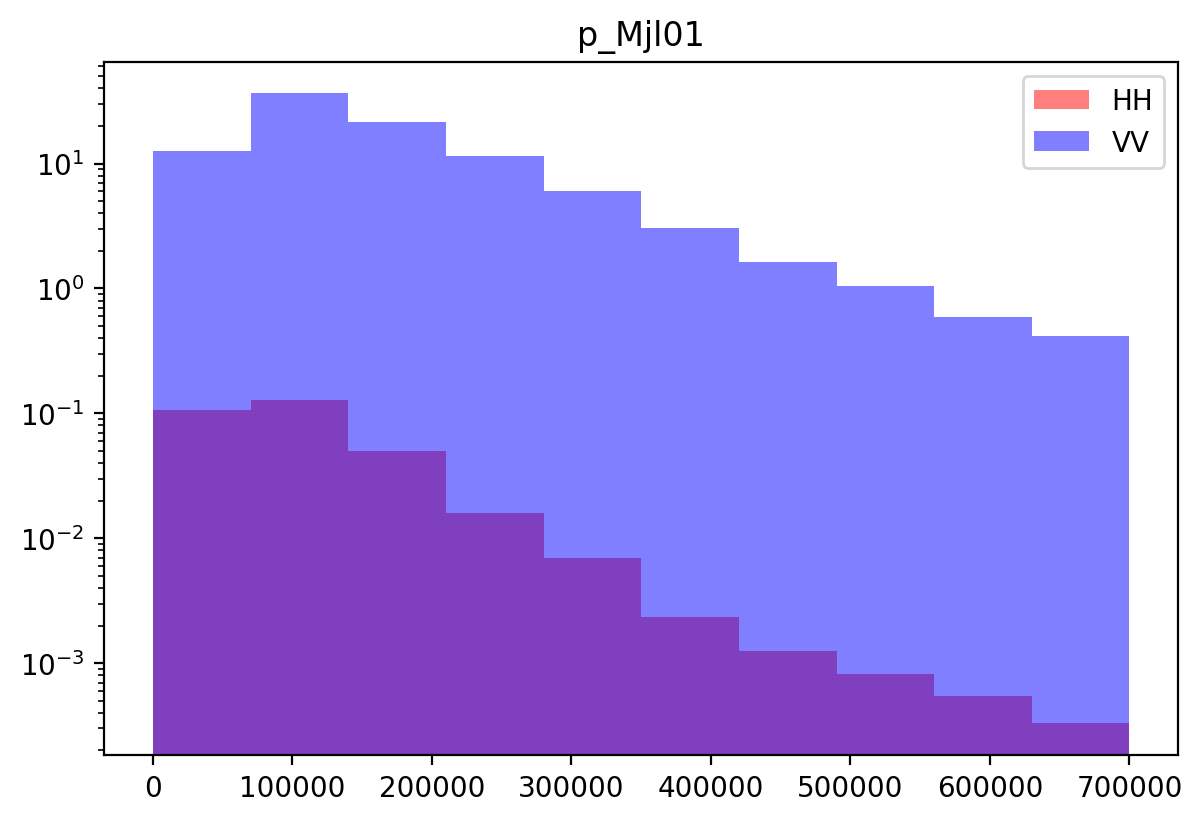

In [1]:
#creating deepcopy of model instances
from copy import deepcopy

#array manipulations
import numpy as np

#dataframe and its manipulations
import pandas as pd

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#selected plotting functions
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#classes for grid search and cross-validation, function for splitting data and evaluating models
from sklearn.model_selection import train_test_split,StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve

#XGBoost library
import xgboost as xgb
import glob
#Python standard libraries
import time
import warnings

#setting default resolution of figures
mpl.rcParams['figure.dpi'] = 200

# import ROOT
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import plot_roc_curve
import uproot
from skopt.plots import plot_objective, plot_histogram

train_variable = ['p_Mjl01','min_DR_tau_lep','p_DR_close_jet_lead_led','min_M_tau_lep','p_DRll01','p_Mjl00','p_Mjjl011']



# train_variable = ['p_Mjl01','min_M_tau_lep','p_DRll01','p_Mjl00','p_Mjjl011']

# input files 
pwd = '/scratch/users/sbataju/2llSS1tauOS/Med/CV'
# all_file = {file_.split('/')[-1]:uproot.open(file_+':nominal').arrays(train_variable+['weight_lumi_xsec'],library="np")  for file_ in list(set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_*.root'))- set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_sig*.root'))- set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_DYMLowZ.root'))- set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_VV.root')))}

input_signal = uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_signal_New_mcA.root'+':nominal').arrays(train_variable+['weight_lumi_xsec'],library="np") 
# # input_signal_weight = pd.DataFrame.from_dict(uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_signal_New_mcA.root'+':nominal').arrays(['weight_lumi_xsec'],library="np"))
input_bkg = uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_VV.root'+':nominal').arrays(train_variable+['weight_lumi_xsec'],library="np") 
# # input_bkg_weight = pd.DataFrame.from_dict(uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_VV.root'+':nominal').arrays(['weight_lumi_xsec'],library="np"))

df_s = pd.DataFrame.from_dict(input_signal)
# input_signal_weight['class']=1
# df_s['class']=1.0
# sig_weight = df_s.pop('weight_lumi_xsec')
df_b = pd.DataFrame.from_dict(input_bkg)
# df_b['class']=0.0
# input_bkg_weight['class']=0
# bkg_weight = df_b.pop('weight_lumi_xsec')


# sig_bkg_weight = input_signal_weight.append(input_bkg_weight)
# print(sig_bkg_weight,'sig_bkg_weight')

# X =df_s.append(df_b)
# X = pd.read_csv('train_test.csv')
# X = X[X["weight_lumi_xsec"]>=0]
# X = X.sample(frac=1).reset_index(drop=True) # Sample  

print("^^^^^^df")
# print(X)
# weight = X.pop("weight_lumi_xsec")
# X = ChangeScale(X,100,train_variable)
# y = X.pop('class')
hist_dict={}
# for key in X[train_variable]:
f = plt.figure()
# plt.subplot(131)
sig,sw =df_s['p_Mjl01'],df_s['weight_lumi_xsec']
bkg,bw =df_b['p_Mjl01'],df_b['weight_lumi_xsec']
s =plt.hist(sig,weights=sw,bins= [0, 70000, 140000, 210000, 280000, 350000, 420000, 490000, 560000, 630000, 700000],label='HH',color='red',alpha=0.5)
b =plt.hist(bkg,weights=bw,bins= [0, 70000, 140000, 210000, 280000, 350000, 420000, 490000, 560000, 630000, 700000],label='VV',color='blue',alpha=0.5)
hist_dict['p_Mjl01'+'s']=s
hist_dict['p_Mjl01'+'b']=b
plt.tight_layout()
plt.yscale("log")
plt.title('p_Mjl01')
plt.legend()
plt.show()
plt.close(f)
    

In [16]:
#creating deepcopy of model instances
from copy import deepcopy

#array manipulations
import numpy as np

#dataframe and its manipulations
import pandas as pd

#plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#selected plotting functions
# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#classes for grid search and cross-validation, function for splitting data and evaluating models
from sklearn.model_selection import train_test_split,StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve

#XGBoost library
import xgboost as xgb
import glob
#Python standard libraries
import time
import warnings

#setting default resolution of figures
mpl.rcParams['figure.dpi'] = 200

# import ROOT
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.metrics import plot_roc_curve
import uproot
from skopt.plots import plot_objective, plot_histogram


def CreateBalancedSampleWeights(y_train, largest_class_weight_coef):
    classes = np.unique(y_train, axis = 0)
    classes.sort()
    class_samples = np.bincount(y_train)
    total_samples = class_samples.sum()
    n_classes = len(class_samples)
    weights = total_samples / (n_classes * class_samples * 1.0)
    class_weight_dict = {key : value for (key, value) in zip(classes, weights)}
    class_weight_dict[classes[1]] = class_weight_dict[classes[1]] * largest_class_weight_coef
    sample_weights = [class_weight_dict[y] for y in y_train]
    return sample_weights


def ChangeScaleAndWeight(df,weight,num_range,variable):
    # ChangeScaleAndWeight(pd.DataFrame,list of weight to be multiplied elementwise, num_range which is scaled to -num_range to +num_range,list of variable to run the sacale and weight):
            
    temp = {}
    for key in df:
        array = df[key]
        cut_array = array[array<(np.mean(array)+3*np.std(array))]
        weight = weight[weight<(np.mean(weight)+3*np.std(weight))]
        if key in variable:

            
            
            abs_value = np.amax(np.abs(cut_array))
            scale_array = cut_array*(num_range/abs_value)
                        
            norm = np.linalg.norm(scale_array)
            normal_array = scale_array/norm
            
            
            temp[key]=[i*j for i,j in zip(normal_array,weight)]
        else:
            temp[key]=cut_array
    print(temp)
    print(np.size(temp))
    return pd.DataFrame(temp)


def ChangeScale(df,num_range,variable):
    temp = {}
    for key in df:
        array = df[key]
        cut_array = array[array<(np.mean(array)+3*np.std(array))]

        if key in variable:
            norm = np.linalg.norm(cut_array)
            normal_array = cut_array/norm
            abs_value = np.amax(np.abs(normal_array))
            scale_array = normal_array*(num_range/abs_value)
            temp[key]=scale_array
        else:
            temp[key]=cut_array
    return pd.DataFrame(temp)



def ChangeNorm(df,variable):
    # Normalizate variable to 1 and return the original df
    temp={}
    for key in df:
        if key in variable:
            norm = np.linalg.norm(df[key])
            temp[key] = df[key]/norm
        else:
            temp[key]=df[key]
    return pd.DataFrame(temp)

def ChangeNormV(var):
    norm = np.linalg.norm(var)
    return var/norm


train_variable = ['p_Mjl01','min_DR_tau_lep','p_DR_close_jet_lead_led','min_M_tau_lep','p_DRll01','p_Mjl00','p_Mjjl011']



# train_variable = ['p_Mjl01','min_M_tau_lep','p_DRll01','p_Mjl00','p_Mjjl011']

# #input files 
pwd = '/scratch/users/sbataju/2llSS1tauOS/Med/CV_xgboost'
all_file = {file_.split('/')[-1]:uproot.open(file_+':nominal').arrays(train_variable+['weight_lumi_xsec'],library="np")  for file_ in list(set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_*.root'))- set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_sig*.root'))- set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_DYMLowZ.root'))- set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_VV.root')))}

input_signal = uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_signal_New_mcA.root'+':nominal').arrays(train_variable+['weight_lumi_xsec'],library="np") 
# input_signal_weight = pd.DataFrame.from_dict(uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_signal_New_mcA.root'+':nominal').arrays(['weight_lumi_xsec'],library="np"))
input_bkg = uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_VV.root'+':nominal').arrays(train_variable+['weight_lumi_xsec'],library="np") 
# input_bkg_weight = pd.DataFrame.from_dict(uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_VV.root'+':nominal').arrays(['weight_lumi_xsec'],library="np"))


# #output files 
signal_file =uproot.recreate(pwd+'/out4/Med_signal_New.root')
bkg_file =uproot.recreate(pwd+'/out4/Med_VV.root')
up_files = { file_.split('/')[-1]:uproot.recreate(pwd+'/out4/'+file_.split('/')[-1]) for file_ in all_file.keys() }


# df = pd.read_csv('train_test.csv')
df_s = pd.DataFrame.from_dict(input_signal)
# input_signal_weight['class']=1
df_s['class']=1.0
# sig_weight = df_s.pop('weight_lumi_xsec')
df_b = pd.DataFrame.from_dict(input_bkg)
df_b['class']=0.0
# input_bkg_weight['class']=0
# bkg_weight = df_b.pop('weight_lumi_xsec')


# sig_bkg_weight = input_signal_weight.append(input_bkg_weight)
# print(sig_bkg_weight,'sig_bkg_weight')

X =df_s.append(df_b)
X = X[X["weight_lumi_xsec"]>=0]
X = X.sample(frac=1).reset_index(drop=True) # Sample  

print("^^^^^^df")
print(X)
weight = X.pop("weight_lumi_xsec")
# X = ChangeScale(X,100,train_variable)
y = X.pop('class')
# X = ChangeNorm(X,train_variable)
# weight = ChangeNormV(weight)
# y = y.replace(100,1)

# data = X
# label = pd.DataFrame(y)
# dtrain = xgb.DMatrix(data, label=label,weight=weight)
# print(dtrain)
ps = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
kfold = ps.split(X,y)
print(kfold)
import optuna

from optuna import Trial, visualization

# import sklearn.datasets
# import xgboost as xgb
def objective(trial):


    dtrain = xgb.DMatrix(X, label=pd.DataFrame(y),weight=weight)
    ratio = float(np.sum(weight[y == 0])) / np.sum(weight[y==1])

    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "gpu_hist",
        "scale_pos_weight":ratio,
        "n_estimators": trial.suggest_int("n_estimators",100,2000,100),
        'colsample_bytree': trial.suggest_float('colsample_bytree',0.3,1.0,log=True),
        'colsample_bynode': trial.suggest_float('colsample_bynode',0.3,1.0,log=True),
        'colsample_bylevel': trial.suggest_float("colsample_bylevel",0.3,1.0,log=True),
         #"booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight",0,15),
        "max_delta_step":trial.suggest_int("max_delta_step",0,10)
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-logloss")
    history = xgb.cv(param, dtrain, num_boost_round=50, callbacks=[pruning_callback],nfold=5,stratified=True)

    mean_log_loss = history["test-logloss-mean"].values[-1]
    return mean_log_loss

best_est = {}
# storage_name = "sqlite:///{}.db".format(study_name)
if __name__ == "__main__":
    study_name = "study_weight2"  # Unique identifier of the study.
    storage_name = "sqlite:///{}.db".format(study_name)
    n_boost =50
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    study = optuna.create_study(study_name=study_name,pruner=pruner, direction="minimize",storage=storage_name)

#     study = optuna.create_study(study_name=study_name,pruner=pruner, direction="minimize",storage=storage_name)
    study.optimize(objective, n_trials=100)
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial for N_trees {} : ".format(n_boost))
    trial = study.best_trial
    print("  Value: {}".format(trial.value))
    print("  Params: ")
    best_est[n_boost] = trial.params
    for key, value in trial.params.items():
        print("    {}= {}".format(key, value))

print(" best values for tress",best_est)




history = study.trials_dataframe()
history.sort_values(by="value", ascending=True).to_csv(f'{study_name}.csv')

^^^^^^df
             p_Mjl01  min_DR_tau_lep  p_DR_close_jet_lead_led  min_M_tau_lep  \
0      117301.213627        2.244555                 1.701997   75765.103460   
1      408899.270198        0.436981                 2.597351   32996.766431   
2      140413.221421        2.651433                 1.744195   82153.630869   
3       83258.287819        1.494227                 2.226474   57336.311680   
4      214564.586216        0.778178                 2.928407   50248.246048   
...              ...             ...                      ...            ...   
48202   70481.190098        2.005189                 3.206156   99960.264407   
48203  177040.368950        1.669736                 2.123106   71530.094956   
48204  105120.118513        1.500736                 1.587722   51641.497476   
48205  194501.090652        0.674623                 2.608912   22851.819971   
48206   70252.968737        0.475948                 1.353215   13214.502842   

       p_DRll01        p_Mjl00

[I 2022-02-16 11:07:18,454] A new study created in RDB with name: study_weight2
[I 2022-02-16 11:07:32,087] Trial 0 finished with value: 0.693147 and parameters: {'n_estimators': 1800, 'colsample_bytree': 0.9595638721577782, 'colsample_bynode': 0.3963102695972985, 'colsample_bylevel': 0.48795276585453345, 'booster': 'gbtree', 'lambda': 0.16584430968324743, 'alpha': 1.4187446382313492e-07, 'min_child_weight': 15, 'max_delta_step': 6, 'max_depth': 9, 'eta': 1.701039620814326e-07, 'gamma': 5.352037593126468e-08, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.693147.
[I 2022-02-16 11:07:47,731] Trial 1 finished with value: 0.693146 and parameters: {'n_estimators': 1700, 'colsample_bytree': 0.8966029537937733, 'colsample_bynode': 0.4842027036147123, 'colsample_bylevel': 0.9742928795667407, 'booster': 'gbtree', 'lambda': 0.04373981537893892, 'alpha': 0.2389934565969595, 'min_child_weight': 9, 'max_delta_step': 9, 'max_depth': 3, 'eta': 1.605766295936049e-07, 'gamma': 0.2805087242

Number of finished trials: 100
Best trial for N_trees 50 : 
  Value: 0.5055488
  Params: 
    alpha= 0.00014113724891195675
    booster= dart
    colsample_bylevel= 0.5524090600489874
    colsample_bynode= 0.3550831480991366
    colsample_bytree= 0.5877485494836213
    eta= 0.2638620966148193
    gamma= 0.006589408982413991
    grow_policy= depthwise
    lambda= 6.315870557449183e-08
    max_delta_step= 2
    max_depth= 4
    min_child_weight= 0
    n_estimators= 600
    normalize_type= tree
    rate_drop= 0.0005058404608207679
    sample_type= uniform
    skip_drop= 0.8631331037644215
 best values for tress {50: {'alpha': 0.00014113724891195675, 'booster': 'dart', 'colsample_bylevel': 0.5524090600489874, 'colsample_bynode': 0.3550831480991366, 'colsample_bytree': 0.5877485494836213, 'eta': 0.2638620966148193, 'gamma': 0.006589408982413991, 'grow_policy': 'depthwise', 'lambda': 6.315870557449183e-08, 'max_delta_step': 2, 'max_depth': 4, 'min_child_weight': 0, 'n_estimators': 600, 'norm

^^^^^^df

 best params 

XBDT VVVVVVVVVVVVVVVVVVVVVVVVV
*** HH VV 


 best params 

XBDT VVVVVVVVVVVVVVVVVVVVVVVVV
*** HH VV 


 best params 

XBDT VVVVVVVVVVVVVVVVVVVVVVVVV
*** HH VV 


 best params 

XBDT VVVVVVVVVVVVVVVVVVVVVVVVV
*** HH VV 


 best params 

XBDT VVVVVVVVVVVVVVVVVVVVVVVVV
*** HH VV 



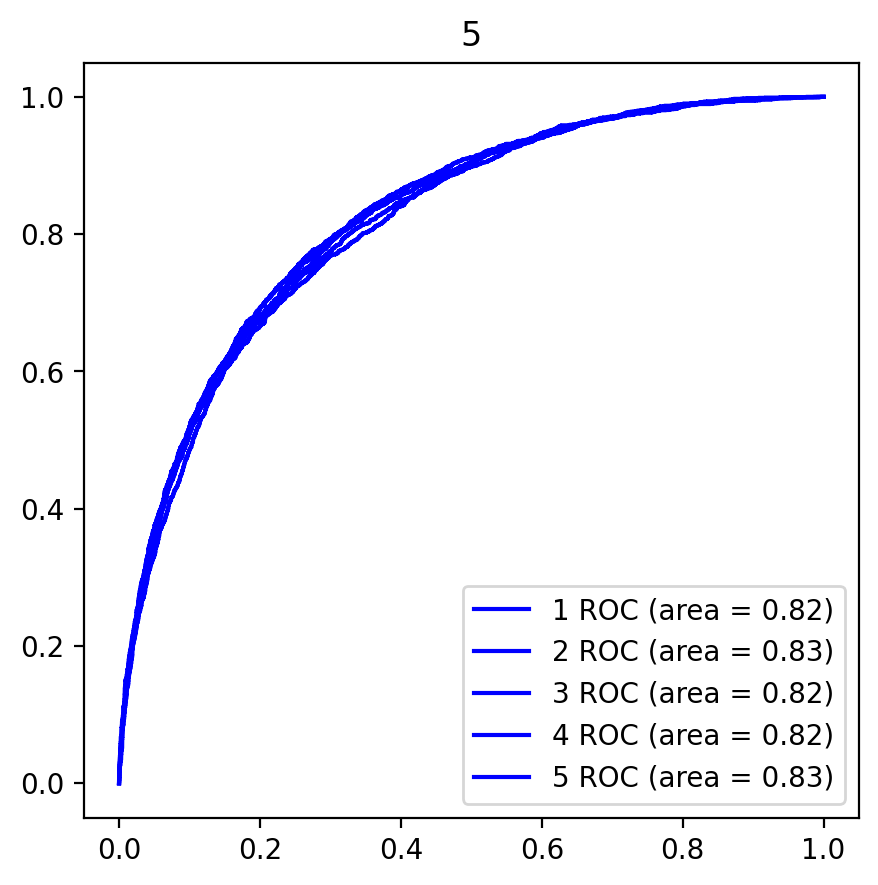

In [41]:
from sklearn.metrics import roc_curve, auc
study_name = "study_weight2"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
# reload study and optimize
study = optuna.load_study(study_name=study_name, storage=storage_name)

pwd = '/scratch/users/sbataju/2llSS1tauOS/Med/CV_xgboost'
all_file = {file_.split('/')[-1]:uproot.open(file_+':nominal').arrays(train_variable+['weight_lumi_xsec'],library="np")  for file_ in list(set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_*.root'))- set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_sig*.root'))- set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_DYMLowZ.root'))- set(glob.glob('/scratch/users/sbataju/2llSS1tauOS/merge/Med_VV.root')))}

input_signal = uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_signal_New_mcA.root'+':nominal').arrays(train_variable+['weight_lumi_xsec'],library="np") 
# input_signal_weight = pd.DataFrame.from_dict(uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_signal_New_mcA.root'+':nominal').arrays(['weight_lumi_xsec'],library="np"))
input_bkg = uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_VV.root'+':nominal').arrays(train_variable+['weight_lumi_xsec'],library="np") 
# input_bkg_weight = pd.DataFrame.from_dict(uproot.open('/scratch/users/sbataju/2llSS1tauOS/merge/Med_VV.root'+':nominal').arrays(['weight_lumi_xsec'],library="np"))


# #output files 
signal_file =uproot.recreate(pwd+'/out4/Med_signal_New.root')
bkg_file =uproot.recreate(pwd+'/out4/Med_VV.root')
up_files = { file_.split('/')[-1]:uproot.recreate(pwd+'/out4/'+file_.split('/')[-1]) for file_ in all_file.keys() }

bkg_fold = {}
for key in all_file.keys():
    Xbkg =  pd.DataFrame.from_dict(all_file[key])
    Xbkg = Xbkg[Xbkg["weight_lumi_xsec"]>=0]
    df1 = Xbkg[train_variable[0]]
    bfold =  [1]*int(len(df1)/5)+[2]*int(len(df1)/5)+[3]*int(len(df1)/5) + [4]*int(len(df1)/5)+ [0]*int(len(df1)/5)
    bkg_fold[key] = PredefinedSplit(bfold)
    # #print([y for x,y in bkg_fold[key].split()],f' bkg_fold  {key}')
    count =0
    
    for train_key,test_key in bkg_fold[key].split():
        count +=1
        bkg_fold[f'{count}'+key+'train'] =Xbkg[train_variable].iloc[train_key]
        bkg_fold[f'{count}'+key+'test'] = Xbkg[train_variable].iloc[test_key]
        bkg_fold[f'{count}'+key+'weight'] = Xbkg['weight_lumi_xsec'].iloc[test_key]
        bkg_fold[f'{count}'+key+'testkey'] = test_key
# X = np.concatenate((X_train0,X_test0),axis=0)
# df = pd.read_csv('train_test.csv')
df_s = pd.DataFrame.from_dict(input_signal)
# input_signal_weight['class']=1
df_s['class']=1.0
# sig_weight = df_s.pop('weight_lumi_xsec')
df_b = pd.DataFrame.from_dict(input_bkg)
df_b['class']=0.0
# input_bkg_weight['class']=0
# bkg_weight = df_b.pop('weight_lumi_xsec')


# sig_bkg_weight = input_signal_weight.append(input_bkg_weight)
# print(sig_bkg_weight,'sig_bkg_weight')

X =df_s.append(df_b)
X = X[X["weight_lumi_xsec"]>=0]
X = X.sample(frac=1).reset_index(drop=True) # Sample  

print("^^^^^^df")
# print(X)
weight = X.pop("weight_lumi_xsec")
# X = ChangeScale(X,100,train_variable)
y = X.pop('class')
# X = ChangeNorm(X,train_variable)
# weight = ChangeNormV(weight)
# y = y.replace(100,1)

# data = X
# label = pd.DataFrame(y)
# dtrain = xgb.DMatrix(data, label=label,weight=weight)
# print(dtrain)
ps = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
c=0
results_dict={}

for train_index, test_index in ps.split(X,y):
# for train_index, test_index in sk.split(X,y):
    c +=1
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_trainw, X_testw = weight.iloc[train_index],weight.iloc[test_index]
#     print('\n xtrain \n')
#     print(X_train)
#     print('\n ytrain \n')
#     print(f'\n signal/Total {sum(y_train)/len(y_train)} \n')
#     print(y_train)
#     print('\n xtest \n')
#     print(X_test)
#     print('\n xtrainw \n')
#     print(X_trainw)
    
#     largest_class_weight_coef = max(pd.Series(y_train).value_counts().values)/X_train.shape[0]
#     w = CreateBalancedSampleWeights(y_train, largest_class_weight_coef)

#     for feature in X_train:
#         print(feature)
#         xx = X_train[feature]
#         figure = plt.figure()
#         plt.hist(xx[y_train==1],pd.DataFrame(w)[y_train==1],label='sig balanced w')
#         plt.hist(xx[y_train==0],pd.DataFrame(w)[y_train==0],label='bkg balanced w')
#         plt.savefig(f'out4/{feature}_{c}.png')
#         plt.close(figure)


    
    # largest_class_weight_coef = max(pd.Series(y).value_counts().values)/df.shape[0]
    # weight = CreateBalancedSampleWeights(y_train, largest_class_weight_coef)
    #XGBClassifier default parameters are not available without fitting the model
    # xgbc0 = cv_result['xgbc_bcv']['best_estimator']                                                                          # 'best_params': OrderedDict([('gamma', 3.2),('learning_rate', 0.06),('max_depth', 7),('n_estimators', 80),('reg_alpha', 0.0),('reg_lambda', 6.4)])}}
    # xgbc0 = xgb.XGBClassifier(objective='binary:logistic', booster='gbtree', eval_metric='logloss', use_label_encoder=False ,gamma=3.2,learning_rate=0.06,max_depth=7,n_estimators=80,reg_alpha=0.0,reg_lambda=6.4)
    print("\n best params \n")
    # print(clf.best_estimator_.get_params())

    dtrain = xgb.DMatrix(X_train, y_train,weight=X_trainw)
    dtest = xgb.DMatrix(X_test, y_test,weight=X_testw)
    params = study.best_trial.params
    ratio = float(np.sum(X_trainw[y == 0])) / np.sum(X_trainw[y==1])
    
    params["objective"]='binary:logistic'
    params["eval_metric"]= "logloss"
    params["tree_method"]="gpu_hist"
    params['scale_pos_weight'] = ratio
#     xgbc0= xgb.XGBClassifier(**params)
    watchlist = [(dtest, 'eval'), (dtrain, 'train')]
    num_round = 50
    xgbc0 = xgb.train(params, dtrain,  num_boost_round=50)
    # xgbc0= xgb.XGBClassifier(**clf.best_estimator_.get_params())
    
    print("XBDT VVVVVVVVVVVVVVVVVVVVVVVVV")
#     print(xgbc0)
#     xgbc0.fit(X_train,y_train,sample_weight=X_trainw)
    # xgbc0.fit(X_train,y_train)



    results_dict[f'clf{c}_train_prob'] = xgbc0.predict(dtrain)
    results_dict[f'clf{c}_test_prob'] = xgbc0.predict(dtest)
    results_dict[f'y_test{c}'] = y_test
    results_dict[f'y_train{c}'] = y_train
    results_dict[f'clf{c}'] = xgbc0
    results_dict[f'X_train{c}'] = X_train
    results_dict[f'X_test{c}'] = X_test

    results_dict[f'{c}_test_weight'] = X_testw

    # results_dict[f'X_test_weight{c}'] = df.iloc[test_index]['weight_lumi_xsec']
    #print("X_weight_sig",X_weight_sig,type(X_weight_sig))
    
    print("*** HH VV \n")
#     print(xgbc0.predict(dtest))
    pd.DataFrame(xgbc0.predict(dtest)).describe()
    # assert False
#     fig = plt.figure()
#     plt.bar(range(len(xgbc0.feature_importances_)), xgbc0.feature_importances_)
#     # plt.set_xticks(results_dict['clf1'].feature_importances_)
#     # plt.set_xticklabels(train_variable)
#     plt.xticks(range(len(xgbc0.feature_importances_)), train_variable)
#     # plt.show()
#     plt.savefig(f'out4/test1_gpu_featureimp_{c}.png')
#     plt.close(fig)

    # fig, ax = plt.subplots(figsize=(12, 6))
    # ax.set_title("Decision Tree")
    # tree_disp = PartialDependenceDisplay.from_estimator(xgbc0, X, train_variable, ax=ax)
    # plt.savefig(f'out4/PDD_{c}.png')
    # plt.close(fig)
    count=c
    for key in all_file.keys():
        #print("#####&&#####")
        #print(f'{c}'+key)
        #print(bkg_fold[f'{count}'+key+'test'])
        bkey = f'{count}'+key+'testkey'
        
        btest = xgb.DMatrix(bkg_fold[f'{count}'+key+'test'],np.ones(len(bkg_fold[f'{count}'+key+'weight'])),  weight=bkg_fold[f'{count}'+key+'weight'])
        results_dict[f'{c}_{key}_Xtest'] = xgbc0.predict(btest)
#         print(" *** bkg \n")
#         print(xgbc0.predict(btest))
    


#combine all bkgs    
all_out1={}
all_outw={}
for key in all_file.keys():
    all_out1[key] = np.concatenate([results_dict[f'{i}_{key}_Xtest'] for i in [1,2,3,4,5] ]) #no of folds
    all_outw[key] = np.concatenate([bkg_fold[f'{i}'+key+'weight'] for i in [1,2,3,4,5] ]) #no of folds
    # #print(all_outw[key])
    up_files[key].mktree("nominal", {"bdt_out1": np.float64,'weight_lumi_xsec':np.float64})
    #print(all_out1[key]," ### btd out", len(all_out1[key]))
    #print(all_outw[key],' ### weight',len(all_outw[key]))
    up_files[key]["nominal"].extend({"bdt_out1":all_out1[key],"weight_lumi_xsec":all_outw[key]})

    
    
# #print(bkg_data)

out1put_sig = np.concatenate([results_dict['clf{}_test_prob'.format(i)][ results_dict['y_test{}'.format(i)]==1] for i in [1,2,3,4,5]],axis=0)
out1put_sigtrain = np.concatenate([results_dict['clf{}_train_prob'.format(i)][ results_dict['y_train{}'.format(i)]==1] for i in [1,2,3,4,5]],axis=0)
out1put_bkg = np.concatenate([results_dict['clf{}_test_prob'.format(i)][ results_dict['y_test{}'.format(i)]==0] for i in [1,2,3,4,5]],axis=0)
out1put_bkgtrain = np.concatenate([results_dict['clf{}_train_prob'.format(i)][ results_dict['y_train{}'.format(i)]==0] for i in [1,2,3,4,5]],axis=0)

out1put_sig_w = np.concatenate([results_dict[f'{i}_test_weight'][results_dict['y_test{}'.format(i)]==1] for i in [1,2,3,4,5]],axis=0)
out1put_bkg_w = np.concatenate([results_dict[f'{i}_test_weight'][results_dict['y_test{}'.format(i)]==0] for i in [1,2,3,4,5]],axis=0)




signal_file.mktree("nominal", {"bdt_out1": np.float64,'weight_lumi_xsec':np.float64})
signal_file["nominal"].extend({"bdt_out1":out1put_sig,"weight_lumi_xsec":out1put_sig_w})
# signal_file["nominal"].extend({"weight_lumi_xsec":out1put_sig_w})


bkg_file.mktree("nominal", {"bdt_out1": np.float64,'weight_lumi_xsec':np.float64})
bkg_file["nominal"].extend({"bdt_out1":out1put_bkg,"weight_lumi_xsec":out1put_bkg_w})
# bkg_file["nominal"].extend({"weight_lumi_xsec":out1put_sig_w})





# assert False
# f, axes = plt.subplots(nrows=4,ncols=1,figsize=(9,18))
# for i,ax in enumerate(axes):
#     i=i+1
#     rfc_disp = plot_roc_curve(results_dict['clf{}'.format(i)], results_dict["X_test{}".format(i)], results_dict["y_test{}".format(i)], ax=ax)
# # plt.show()
# plt.savefig('out4/test1_gpu_roc.png')
# plt.close(f)

fig  = plt.figure(figsize=(5, 5))
avg_roc = []
avg_fpr = []
avg_tpr = []
tprs = []
base_fpr = np.linspace(0, 1, 101)
for i in [1,2,3,4,5]:
    roc1 = roc_curve(results_dict['y_test{}'.format(i)], results_dict['clf{}_test_prob'.format(i)])

    fpr,tpr,_=roc1
    avg_roc.append(roc1)
    avg_fpr.append(fpr)
    avg_tpr.append(tpr)
    
    plt.plot(fpr, tpr, 'b',label=f'{i} ROC (area = {auc(fpr,tpr):.2f})')
    plt.title(i)
    plt.legend()
    plt.savefig(f'out4/test1_gpu_{i}_roc.png')
#     plt.show()
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

fig = plt.figure()
plt.plot(base_fpr, mean_tprs, 'r')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.legend()
plt.savefig('out4/test1_gpu_combroc.png')
# plt.show()
plt.close(fig)
# #print([len(i) for i in avg_fpr])
# #print([len(i) for i in avg_tpr])
# #print([len(i) for i in avg_roc])

fig = plt.figure()
plt.hist(out1put_sig,color='blue',bins='auto',label='Test, Signal',density=True,alpha=0.4)
plt.hist(out1put_sigtrain,color='blue',bins='auto',label='Train, Signal',density=True,alpha=0.4,histtype='step')
plt.hist(out1put_bkg,color='red',bins='auto',label='Test, Bkg',density=True,alpha=0.4)
plt.hist(out1put_bkgtrain,color='red',bins='auto',label='Train, Bkg',density=True,histtype='step')
# plt.yscale('log')
plt.legend()
# plt.show()

plt.savefig('out4/test1_gpu_trainvstest.png')
plt.close(fig)

fig = plt.figure()
plt.hist(out1put_sig,color='blue',bins='auto',label='Test, Signal',density=True,alpha=0.4)
plt.hist(out1put_sigtrain,color='blue',bins='auto',label='Train, Signal',density=True,alpha=0.4,histtype='step')
plt.hist(out1put_bkg,color='red',bins='auto',label='Test, Bkg',density=True,alpha=0.4)
plt.hist(out1put_bkgtrain,color='red',bins='auto',label='Train, Bkg',density=True,histtype='step')
plt.yscale('log')
plt.legend()
# plt.show()

plt.savefig('out4/test1_gpu_trainvstestlog.png')
plt.close(fig)



In [18]:
visualization.plot_slice(study, target_name = 'Average Validation LogLoss').write_html('plot_slice.html')
visualization.plot_param_importances(study, target_name = 'Average Validation LogLoss').write_html('plot_param_importances.html')
visualization.plot_parallel_coordinate(study, target_name = 'Average Validation LogLoss').write_html('plot_parallel_coordinate.html')
visualization.plot_optimization_history(study, target_name = 'Average Validation LogLoss').write_html('plot_optimization_history.html')



In [35]:
hist_dict['p_Mjl01s'][0]
print(sum(hist_dict['p_Mjl01s'][0]))
print(sum(hist_dict['p_Mjl01b'][0]))

0.31307104229927063
94.96167850494385


In [36]:
yeild =  [0.10661671412790864, 0.12880568589360236, 0.049648972496948537, 0.015794802914466999, 0.0069446985178238663, 0.0023256716949617839, 0.00124888738679374, 0.00081167969165107934, 0.00054130110856931424, 0.00079414047604586813]
print(sum(yeild))
by =[12.65531524667783, 36.406774306856164, 21.535834216760033, 11.583934998926907, 6.0609497834098534, 3.0380046080076681, 1.6188186052391842, 1.0554734900401854, 0.5902544325240342, 1.1332281706440881]
print(sum(by))

0.3135325543087722
95.67858785908595


In [37]:
hist_dict['p_Mjl01s'][0]-yeild

array([-2.33730182e-08,  4.43204336e-07,  1.17077865e-07,  4.87555656e-07,
        1.36668181e-07, -1.76651156e-08, -2.10671374e-08,  1.65372512e-07,
       -1.52704160e-09, -4.62798256e-04])

In [38]:
hist_dict['p_Mjl01b'][0]-by

array([-6.52322812e-06,  1.62338652e-04,  8.87873904e-05,  7.22642567e-05,
        5.48552620e-05,  1.42364649e-04, -7.47087548e-05, -2.30505871e-05,
        1.30478065e-06, -7.17326987e-01])

In [40]:
700000+70000

770000

In [ ]:
# y = X.pop('class')
hist_dict2={}
# for key in X[train_variable]:
f = plt.figure()
# plt.subplot(131)
sig,sw =df_s['p_Mjl01'],df_s['weight_lumi_xsec']
bkg,bw =df_b['p_Mjl01'],df_b['weight_lumi_xsec']
s =plt.hist(sig,weights=sw,bins= [0, 70000, 140000, 210000, 280000, 350000, 420000, 490000, 560000, 630000, 700000],label='HH',color='red',alpha=0.5,density=True,stacked=True)
b =plt.hist(bkg,weights=bw,bins= [0, 70000, 140000, 210000, 280000, 350000, 420000, 490000, 560000, 630000, 700000],label='VV',color='blue',alpha=0.5,density=True,stacked=True)
hist_dict2['p_Mjl01'+'s']=s
hist_dict2['p_Mjl01'+'b']=b
plt.tight_layout()
plt.yscale("log")
plt.title('p_Mjl01')
plt.legend()
plt.show()
plt.close(f)
    

In [42]:

print(sum(hist_dict2['p_Mjl01s'][0]))
print(sum(hist_dict2['p_Mjl01b'][0]))

1.4285714285714289e-05
1.4285714429181831e-05


In [23]:
out1put_sig_w


array([1.6276050e-05, 2.5453272e-05, 7.9645606e-06, ..., 1.8529543e-05,
       1.2553954e-05, 2.0177567e-05], dtype=float32)

In [24]:
out1put_sig

array([0.17996162, 0.65298545, 0.8222488 , ..., 0.88545626, 0.6635427 ,
       0.29250303], dtype=float32)

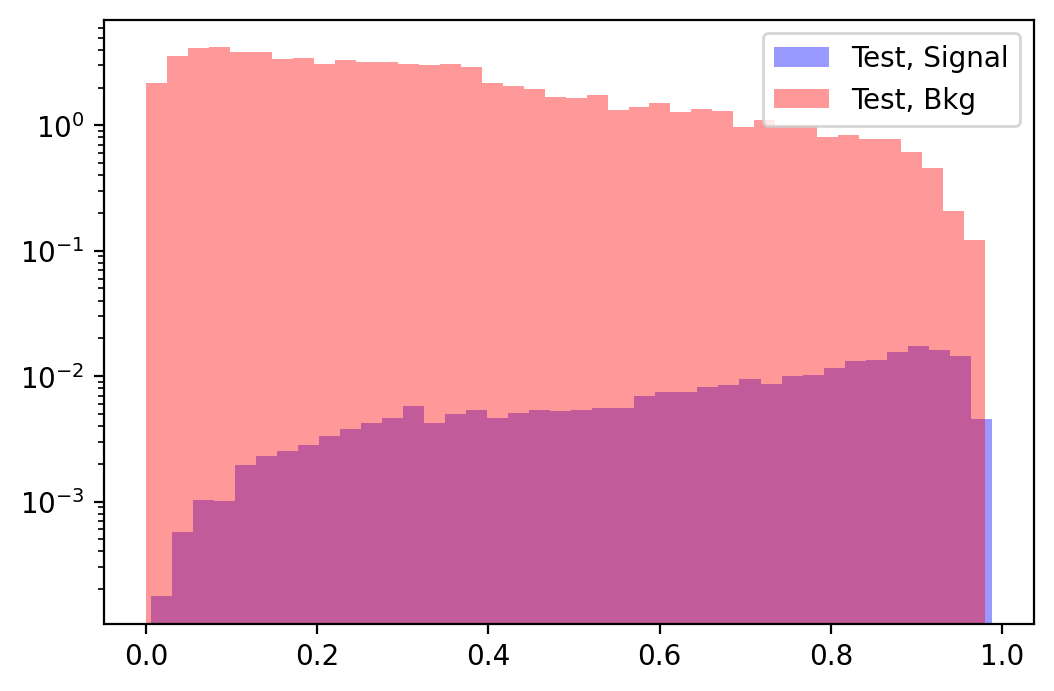

In [33]:
fig = plt.figure()
ss =plt.hist(out1put_sig,weights=out1put_sig_w,color='blue',bins=40,label='Test, Signal',alpha=0.4)
# plt.hist(out1put_sigtrain,color='blue',bins='auto',label='Train, Signal',alpha=0.4,histtype='step')
bb= plt.hist(out1put_bkg,weights=out1put_bkg_w,color='red',bins=40,label='Test, Bkg',alpha=0.4)
# plt.hist(out1put_bkgtrain,color='red',bins='auto',label='Train, Bkg',histtype='step')
plt.yscale('log')
plt.legend()
plt.show()

In [32]:
print(ss[0])
print(sum(ss[0]))

[ 12.  22.  46.  55.  98. 105. 102. 124. 154. 170. 194. 198. 258. 217.
 244. 254. 215. 228. 239. 219. 248. 244. 241. 291. 320. 309. 357. 374.
 397. 371. 387. 416. 450. 510. 519. 588. 638. 591. 538. 157.]
11100.0


In [ ]:
ys = [0.00016051434658947983, 0.00059192757055370748, 0.0009117199512703178, 0.0010130525816975933, 0.0017170730335873685, 0.0023700666773365242, 0.0025975087935705687, 0.0028460989427117056, 0.0033890729533538888, 0.0038952723749048346, 0.0040848209016530745, 0.0047843942335674683, 0.0058718084323430286, 0.0042838955841943971, 0.0050701932421475249, 0.0055849936592835547, 0.0045791503063838945, 0.005208308640128223, 0.0057685314564093204, 0.0053188743802081717, 0.0052647415772213435, 0.0054850470339715685, 0.0064053300427053261, 0.0070415701756303406, 0.0074269401134472446, 0.0080967003832483897, 0.0077499407487948702, 0.0091118258396534202, 0.0099758131282925433, 0.0088985560155947496, 0.010228704100200048, 0.011256111049542383, 0.012330452930658986, 0.013474802028872634, 0.013779001241346123, 0.016990458035697226, 0.016438065990078243, 0.017490056297862822, 0.0099633766298135029, 0.0013741352836404985]
